In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
import time
from IPython.display import clear_output

In [2]:
# Set device for PyTorch (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load datasets
print("Loading datasets...")
df_train_faultfree = pyreadr.read_r("TEP_FaultFree_Training.RData")['fault_free_training']
df_train_faulty = pyreadr.read_r("TEP_Faulty_Training.RData")['faulty_training']
df_test_faulty = pyreadr.read_r("TEP_Faulty_Testing.RData")['faulty_testing']

print(f"Training fault-free data shape: {df_train_faultfree.shape}")
print(f"Training faulty data shape: {df_train_faulty.shape}")
print(f"Testing faulty data shape: {df_test_faulty.shape}")

Loading datasets...
Training fault-free data shape: (250000, 55)
Training faulty data shape: (5000000, 55)
Testing faulty data shape: (9600000, 55)


In [4]:
# Kalman Filter implementation for smoothing predictions
class KalmanFilter:
    """
    Simple implementation of Kalman filter for 1D signal smoothing
    """
    def __init__(self, dim_x, Q=1e-4, R=0.1):
        """
        Initialize Kalman filter
        
        Args:
            dim_x: State dimension
            Q: Process noise covariance
            R: Measurement noise covariance
        """
        self.dim_x = dim_x
        self.Q = Q
        self.R = R
        
    def filter(self, y_noisy):
        """
        Apply Kalman filtering to noisy observations
        
        Args:
            y_noisy: Noisy observations
            
        Returns:
            x_est: Filtered (smoothed) state estimates
        """
        n = len(y_noisy)
        x_est = np.zeros(n)  # State estimates
        P = np.zeros(n)      # Error covariance
        
        # Initial state and covariance
        x_est[0] = y_noisy[0]
        P[0] = 1.0
        
        for k in tqdm(range(1, n), desc="Kalman filtering", leave=False):
            # Prediction step
            x_pred = x_est[k-1]      # State prediction
            P_pred = P[k-1] + self.Q  # Covariance prediction
            
            # Update step with measurement
            K = P_pred / (P_pred + self.R)  # Kalman gain
            x_est[k] = x_pred + K * (y_noisy[k] - x_pred)  # State update
            P[k] = (1 - K) * P_pred   # Covariance update
            
        return x_est

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Positional Encoding for Transformer model
class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer model
    Adds information about position of tokens in the sequence
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Add positional encoding to input
        
        Args:
            x: Input tensor of shape (batch_size, seq_length, d_model)
            
        Returns:
            Tensor with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Transformer-based anomaly detection model
class TransformerPredictor(nn.Module):
    """
    Transformer model for anomaly detection
    """
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        """
        Initialize Transformer model
        
        Args:
            input_dim: Input feature dimension
            d_model: Hidden dimension for the model
            nhead: Number of attention heads
            num_layers: Number of transformer encoder layers
            dropout: Dropout probability
        """
        super().__init__()
        
        # Input embedding
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=256, 
            dropout=dropout, 
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer for anomaly detection (binary classification)
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        """
        Forward pass of the model
        
        Args:
            x: Input tensor of shape (batch_size, seq_length, input_dim)
            
        Returns:
            Output tensor of shape (batch_size, 1)
        """
        batch_size, seq_len, _ = x.size()
        
        # Embedding and scale
        x = self.embedding(x) * np.sqrt(self.embedding.out_features)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Create causal mask (lower triangular)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        
        # Pass through transformer encoder
        x = self.transformer_encoder(x, mask=mask)
        
        # Get the output for the last position
        output = self.fc(x[:, -1, :])
        
        return output

In [7]:
# Create PyTorch dataset
class TEPDataset(Dataset):
    """
    TEP dataset for PyTorch DataLoader
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# Create sliding window time series input
def create_dataset(X, y, lookback=15):
    """
    Create sliding window dataset: input is lookback steps, target is the next step
    
    Args:
        X: Features array
        y: Labels array
        lookback: Number of time steps to look back
        
    Returns:
        X_windows: Tensor of shape (n_samples, lookback, n_features)
        y_windows: Tensor of target values
    """
    print(f"Creating sliding windows with lookback={lookback}...")
    X_windows, y_windows = [], []
    
    for i in tqdm(range(len(X) - lookback), desc="Creating windows"):
        X_windows.append(X[i:i+lookback])
        y_windows.append(y[i+lookback])
    
    return torch.tensor(np.array(X_windows), dtype=torch.float32), torch.tensor(np.array(y_windows), dtype=torch.float32)

In [9]:
# Neural network anomaly detector
class NeuralAnomalyDetector:
    """
    Neural network-based anomaly detector with Transformer model and Kalman filtering
    """
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1, Q=1e-4, R=0.1):
        """
        Initialize detector
        
        Args:
            input_dim: Input feature dimension
            d_model: Hidden dimension for transformer
            nhead: Number of attention heads
            num_layers: Number of transformer layers
            dropout: Dropout probability
            Q: Process noise for Kalman filter
            R: Measurement noise for Kalman filter
        """
        self.transformer = TransformerPredictor(input_dim, d_model, nhead, num_layers, dropout)
        self.kalman_filter = KalmanFilter(1, Q, R)
        self.device = device
        self.transformer.to(self.device)
        
        # Training related variables
        self.train_losses = []
        self.val_losses = []
        self.epochs = []
        self.current_epoch = 0
        
        # Checkpoint directory
        self.checkpoint_dir = 'checkpoints'
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        
    def save_checkpoint(self, fault_type, epoch, optimizer, loss, filename=None):
        """
        Save model checkpoint
        
        Args:
            fault_type: Type of fault the model is trained for
            epoch: Current epoch
            optimizer: Optimizer state
            loss: Current loss value
            filename: Name of the checkpoint file
        """
        if filename is None:
            filename = f'fault_{fault_type}_checkpoint.pth'
        path = os.path.join(self.checkpoint_dir, filename)
        torch.save({
            'fault_type': fault_type,
            'epoch': epoch,
            'model_state_dict': self.transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'epochs': self.epochs,
            'current_epoch': self.current_epoch
        }, path)
        print(f"Checkpoint saved at {path}")
        
    def load_checkpoint(self, fault_type, optimizer, filename=None):
        """
        Load model checkpoint
        
        Args:
            fault_type: Type of fault the model is trained for
            optimizer: Optimizer to load state into
            filename: Name of the checkpoint file
            
        Returns:
            epoch: Epoch of the checkpoint
            loss: Loss value of the checkpoint
        """
        if filename is None:
            filename = f'fault_{fault_type}_checkpoint.pth'
        path = os.path.join(self.checkpoint_dir, filename)
        if os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.transformer.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint['train_losses']
            self.val_losses = checkpoint['val_losses']
            self.epochs = checkpoint['epochs']
            self.current_epoch = checkpoint['current_epoch']
            print(f"Checkpoint for fault type {fault_type} loaded from {path}, resuming from epoch {self.current_epoch}")
            return checkpoint['epoch'], checkpoint['loss']
        else:
            print(f"No checkpoint found for fault type {fault_type} at {path}, starting from scratch")
            return 0, float('inf')
        
    def validate(self, val_loader):
        """
        Validate model on validation set
        
        Args:
            val_loader: Validation data loader
            
        Returns:
            avg_val_loss: Average validation loss
        """
        self.transformer.eval()
        criterion = nn.BCEWithLogitsLoss()
        total_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                outputs = self.transformer(X_batch).squeeze()
                
                # Handle case when batch size is 1
                if outputs.ndim == 0:
                    outputs = outputs.unsqueeze(0)
                    
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()
                
        avg_val_loss = total_loss / len(val_loader)
        return avg_val_loss
        
    def train_model(self, fault_type, train_loader, val_loader=None, num_epochs=30, lr=1e-3, resume=True, save_interval=5):
        """
        Train the model with checkpoint support and real-time plotting
        
        Args:
            fault_type: Type of fault the model is trained for
            train_loader: Training data loader
            val_loader: Validation data loader
            num_epochs: Number of epochs to train
            lr: Learning rate
            resume: Whether to resume from checkpoint
            save_interval: Interval to save checkpoints
        """
        # Record current fault type
        self.fault_type = fault_type
        
        # Use BCE loss for anomaly detection (binary classification)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.transformer.parameters(), lr=lr)
        
        # Try to load checkpoint if resume is True
        start_epoch = 0
        best_loss = float('inf')
        if resume:
            start_epoch, best_loss = self.load_checkpoint(fault_type, optimizer)
            self.current_epoch = start_epoch
        
        # Clear previous training records (if starting from scratch)
        if start_epoch == 0:
            self.train_losses = []
            self.val_losses = []
            self.epochs = []
        
        self.transformer.train()
        
        print(f"Starting training for fault type {fault_type}...")
        try:
            for epoch in range(start_epoch, start_epoch + num_epochs):
                self.current_epoch = epoch
                epoch_start_time = time.time()
                total_loss = 0.0
                
                batch_pbar = tqdm(train_loader, desc=f"Fault {fault_type} - Epoch {epoch+1}/{start_epoch + num_epochs}", leave=False)
                
                for X_batch, y_batch in batch_pbar:
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.transformer(X_batch).squeeze()
                    
                    # Handle case when batch size is 1
                    if outputs.ndim == 0:
                        outputs = outputs.unsqueeze(0)
                        
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    batch_pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
                
                # Calculate average training loss
                avg_train_loss = total_loss / len(train_loader)
                
                # Calculate validation loss if validation loader is provided
                avg_val_loss = None
                if val_loader:
                    avg_val_loss = self.validate(val_loader)
                    self.val_losses.append(avg_val_loss)
                
                # Record losses and epoch
                self.train_losses.append(avg_train_loss)
                self.epochs.append(epoch + 1)
                
                # Print epoch summary
                epoch_time = time.time() - epoch_start_time
                status = f"Fault {fault_type} - Epoch {epoch+1}/{start_epoch + num_epochs}, Train Loss: {avg_train_loss:.4f}"
                if avg_val_loss:
                    status += f", Val Loss: {avg_val_loss:.4f}"
                status += f", Time: {epoch_time:.2f}s"
                print(status)
                
                # Visualize training progress
                if (epoch + 1) % 5 == 0:
                    plt.figure(figsize=(10, 6))
                    plt.plot(self.epochs, self.train_losses, 'b-', label='Training Loss')
                    if self.val_losses:
                        plt.plot(self.epochs, self.val_losses, 'r-', label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.title(f'Fault Type {fault_type} - Training and Validation Loss')
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'fault_{fault_type}_loss_epoch_{epoch+1}.png')
                    plt.close()
                
                # Save checkpoint
                if (epoch + 1) % save_interval == 0:
                    self.save_checkpoint(fault_type, epoch + 1, optimizer, avg_train_loss, f'fault_{fault_type}_checkpoint_epoch_{epoch+1}.pth')
                
                # Save best model
                current_loss = avg_val_loss if avg_val_loss else avg_train_loss
                if current_loss < best_loss:
                    best_loss = current_loss
                    self.save_checkpoint(fault_type, epoch + 1, optimizer, current_loss, f'fault_{fault_type}_best_model.pth')
                    print(f"New best model for fault type {fault_type} saved with loss: {current_loss:.4f}")
                
        except KeyboardInterrupt:
            print(f"Training for fault type {fault_type} interrupted! Saving checkpoint...")
            self.save_checkpoint(fault_type, epoch + 1, optimizer, avg_train_loss, f'fault_{fault_type}_interrupted_checkpoint.pth')
        
        # Save final model
        self.save_checkpoint(fault_type, start_epoch + num_epochs, optimizer, self.train_losses[-1], f'fault_{fault_type}_final_model.pth')
        print(f"Training for fault type {fault_type} complete!")
    
    def predict(self, X, threshold=0.5):
        """
        Make predictions using the neural network and apply Kalman filtering
        
        Args:
            X: Input data tensor or numpy array
            threshold: Threshold for binary classification
            
        Returns:
            anomalies: Binary anomaly predictions
            filtered_scores: Continuous anomaly scores after Kalman filtering
        """
        self.transformer.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            outputs = self.transformer(X_tensor).squeeze()
            
            # Handle case when batch size is 1
            if outputs.ndim == 0:
                outputs = outputs.unsqueeze(0)
                
            raw_scores = torch.sigmoid(outputs).cpu().numpy()
            
            # Apply Kalman filtering to smooth predictions
            filtered_scores = self.kalman_filter.filter(raw_scores)
            
            # Determine anomalies based on threshold
            anomalies = filtered_scores > threshold
            
            return anomalies, filtered_scores

# Train and evaluate model for each fault type
def train_and_evaluate_fault_model(fault_type, df_train_faultfree, df_train_faulty, df_test_faulty, lookback=15, num_epochs=30, batch_size=16):
    """
    Train and evaluate a model for a specific fault type
    
    Args:
        fault_type: Type of fault to train for
        df_train_faultfree: DataFrame with fault-free training data
        df_train_faulty: DataFrame with faulty training data
        df_test_faulty: DataFrame with faulty testing data
        lookback: Number of time steps to look back
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
        
    Returns:
        results: Dictionary with evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Processing Fault Type {fault_type}")
    print(f"{'='*80}")
    
    # Prepare training data
    # Extract data for current fault type from training set
    train_fault_data = df_train_faulty[df_train_faulty['faultNumber'] == fault_type]
    
    if len(train_fault_data) == 0:
        print(f"No training data found for fault type {fault_type}. Skipping...")
        return None
    
    # Prepare feature data (normal data and current fault type data)
    X_train_normal = df_train_faultfree.iloc[:, 3:].values
    X_train_fault = train_fault_data.iloc[:, 3:].values
    
    # Create labels: normal=0, fault=1
    # Note: In training set, fault is introduced after sample 20 (1 hour, one sample every 3 minutes)
    y_train_normal = np.zeros(len(X_train_normal))
    y_train_fault = np.ones(len(X_train_fault))
    y_train_fault[:20] = 0  # First 20 samples are normal
    
    # Combine training data
    X_train = np.vstack([X_train_normal, X_train_fault])
    y_train = np.concatenate([y_train_normal, y_train_fault])
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Create sliding window dataset
    X_train_windows, y_train_windows = create_dataset(X_train_scaled, y_train, lookback)
    
    # Create training dataset
    train_dataset = TEPDataset(X_train_windows, y_train_windows)
    
    # Split training and validation sets
    from sklearn.model_selection import train_test_split
    
    train_indices, val_indices = train_test_split(
        range(len(train_dataset)), 
        test_size=0.1, 
        random_state=42
    )
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler
    )
    
    val_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=val_sampler
    )
    
    # Initialize model
    print(f"Initializing model for fault type {fault_type}...")
    feature_dim = X_train_windows.shape[2]
    model = NeuralAnomalyDetector(
        input_dim=feature_dim,
        d_model=64,      
        nhead=4,         
        num_layers=2,
        dropout=0.1,
        Q=1e-5,          
        R=0.1            
    )
    
    # Train model
    model.train_model(
        fault_type=fault_type,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        lr=1e-3,
        resume=True,
        save_interval=5
    )
    
    # Prepare test data
    # Extract data for current fault type from test set
    test_fault_data = df_test_faulty[df_test_faulty['faultNumber'] == fault_type]
    
    if len(test_fault_data) == 0:
        print(f"No test data found for fault type {fault_type}. Skipping evaluation...")
        return model
    
    # Prepare test features
    X_test = test_fault_data.iloc[:, 3:].values
    
    # Note: In test set, fault is introduced after sample 160 (8 hours, one sample every 3 minutes)
    y_test = np.ones(len(X_test))
    y_test[:160] = 0  # First 160 samples are normal
    
    # Normalize test data (using same parameters as training data)
    X_test_scaled = scaler.transform(X_test)
    
    # Create sliding window test dataset
    X_test_windows, y_test_windows = create_dataset(X_test_scaled, y_test, lookback)
    
    # Create test data loader
    test_dataset = TEPDataset(X_test_windows, y_test_windows)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate model
    print(f"Evaluating model for fault type {fault_type}...")
    
    # Get predictions on test data
    anomalies, scores = model.predict(X_test_windows)
    
    # Calculate evaluation metrics
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_windows.numpy(), anomalies, average='binary')
        accuracy = accuracy_score(y_test_windows.numpy(), anomalies)
        
        results = {
            'fault_type': fault_type,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy
        }
        
        print(f"Fault Type {fault_type} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

        gc.collect()
        torch.cuda.empty_cache()
    
        return results
    
    except Exception as e:
        print(f"Error evaluating fault type {fault_type}: {str(e)}")
    
        gc.collect()
        torch.cuda.empty_cache()
    
        return {'fault_type': fault_type, 'error': str(e)}
        
        # Visualize results
        plt.figure(figsize=(12, 8))
        
        # Top plot: anomaly scores and detected anomalies
        plt.subplot(2, 1, 1)
        plt.plot(scores, label='Anomaly Score')
        plt.scatter(np.where(anomalies)[0], scores[anomalies], color='r', label='Detected Anomalies')
        plt.axvline(160-lookback, c='g', linestyle='--', label='Fault Introduction')
        plt.axhline(0.5, c='k', linestyle='--', label='Threshold')
        plt.title(f'Fault Type {fault_type} - Anomaly Detection Results')
        plt.legend()
        
        # Bottom plot: true labels vs predicted labels
        plt.subplot(2, 1, 2)
        plt.plot(y_test_windows.numpy(), 'g-', label='True Labels')
        plt.plot(anomalies, 'r--', label='Predicted Labels')
        plt.axvline(160-lookback, c='g', linestyle='--', label='Fault Introduction')
        plt.title(f'Fault Type {fault_type} - True vs Predicted Labels')
        plt.xlabel('Sample')
        plt.ylabel('Label (0=Normal, 1=Fault)')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'fault_{fault_type}_evaluation.png')
        plt.close()
        
        return results
    
    except Exception as e:
        print(f"Error evaluating fault type {fault_type}: {str(e)}")
        return {'fault_type': fault_type, 'error': str(e)}

In [10]:
# Main function
def main():
    """
    Main function to train and evaluate models for all fault types
    """
    # Set parameters
    lookback = 15
    num_epochs = 30
    batch_size = 16
    
    # Get all fault types
    fault_types = sorted(df_train_faulty['faultNumber'].unique())
    print(f"Found fault types: {fault_types}")
    
    # Store results for all fault types
    all_results = {}
    
    # Train and evaluate model for each fault type individually
    for fault_type in fault_types:
        print(f"\nProcessing fault type {fault_type}...")
        result = train_and_evaluate_fault_model(
            fault_type, 
            df_train_faultfree, 
            df_train_faulty, 
            df_test_faulty,
            lookback=lookback,
            num_epochs=num_epochs,
            batch_size=batch_size
        )
        
        if result:
            all_results[fault_type] = result
    
    # Summarize results
    print("\n" + "="*80)
    print("Summary of Results for All Fault Types")
    print("="*80)
    
    f1_scores = []
    accuracies = []
    
    for fault_type, result in all_results.items():
        if 'f1' in result:
            print(f"Fault {fault_type} - F1: {result['f1']:.4f}, Accuracy: {result['accuracy']:.4f}")
            f1_scores.append(result['f1'])
            accuracies.append(result['accuracy'])
    
    if f1_scores:
        print("\nOverall Performance:")
        print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
        print(f"Average Accuracy: {np.mean(accuracies):.4f}")
        
        # Visualize F1 scores for different fault types
        plt.figure(figsize=(15, 7))
        fault_types = list(all_results.keys())
        f1_values = [result.get('f1', 0) if 'f1' in result else 0 for result in all_results.values()]
        
        plt.bar(fault_types, f1_values)
        plt.title('F1 Score by Fault Type')
        plt.xlabel('Fault Type')
        plt.ylabel('F1 Score')
        plt.xticks(fault_types)
        plt.ylim(0, 1.0)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.savefig('fault_comparison_f1.png')
        
        # Visualize precision and recall for different fault types
        plt.figure(figsize=(15, 7))
        precision_values = [result.get('precision', 0) if 'precision' in result else 0 for result in all_results.values()]
        recall_values = [result.get('recall', 0) if 'recall' in result else 0 for result in all_results.values()]
        
        x = np.arange(len(fault_types))
        width = 0.35
        
        plt.bar(x - width/2, precision_values, width, label='Precision')
        plt.bar(x + width/2, recall_values, width, label='Recall')
        
        plt.title('Precision and Recall by Fault Type')
        plt.xlabel('Fault Type')
        plt.ylabel('Score')
        plt.xticks(x, fault_types)
        plt.ylim(0, 1.0)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.savefig('fault_comparison_precision_recall.png')
        
        plt.show()
    
    return all_results

In [ ]:
# Execute main function
if __name__ == "__main__":
    all_results = main()

Found fault types: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Processing fault type 1...

Processing Fault Type 1
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1702739.68it/s]


Initializing model for fault type 1...
No checkpoint found for fault type 1 at checkpoints\fault_1_checkpoint.pth, starting from scratch
Starting training for fault type 1...


Fault 1 - Epoch 1/30, Train Loss: 0.0435, Val Loss: 0.0415, Time: 456.67s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0415


Fault 1 - Epoch 2/30, Train Loss: 0.0400, Val Loss: 0.0417, Time: 383.82s


Fault 1 - Epoch 3/30, Train Loss: 0.0396, Val Loss: 0.0389, Time: 386.03s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0389


Fault 1 - Epoch 4/30, Train Loss: 0.0375, Val Loss: 0.0358, Time: 358.82s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0358


Fault 1 - Epoch 5/30, Train Loss: 0.0333, Val Loss: 0.0308, Time: 360.97s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0308


Fault 1 - Epoch 6/30, Train Loss: 0.0310, Val Loss: 0.0321, Time: 367.96s


Fault 1 - Epoch 7/30, Train Loss: 0.0296, Val Loss: 0.0297, Time: 367.68s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0297


Fault 1 - Epoch 8/30, Train Loss: 0.0286, Val Loss: 0.0288, Time: 365.84s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0288


Fault 1 - Epoch 9/30, Train Loss: 0.0261, Val Loss: 0.0237, Time: 377.97s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0237


Fault 1 - Epoch 10/30, Train Loss: 0.0218, Val Loss: 0.0218, Time: 393.04s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0218


Fault 1 - Epoch 11/30, Train Loss: 0.0202, Val Loss: 0.0230, Time: 385.29s


Fault 1 - Epoch 12/30, Train Loss: 0.0196, Val Loss: 0.0199, Time: 369.62s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0199


Fault 1 - Epoch 13/30, Train Loss: 0.0194, Val Loss: 0.0202, Time: 387.38s


Fault 1 - Epoch 14/30, Train Loss: 0.0190, Val Loss: 0.0212, Time: 384.38s


Fault 1 - Epoch 15/30, Train Loss: 0.0184, Val Loss: 0.0184, Time: 391.82s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0184


Fault 1 - Epoch 16/30, Train Loss: 0.0182, Val Loss: 0.0191, Time: 389.53s


Fault 1 - Epoch 17/30, Train Loss: 0.0182, Val Loss: 0.0182, Time: 392.83s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0182


Fault 1 - Epoch 18/30, Train Loss: 0.0180, Val Loss: 0.0180, Time: 388.17s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0180


Fault 1 - Epoch 19/30, Train Loss: 0.0173, Val Loss: 0.0182, Time: 384.54s


Fault 1 - Epoch 20/30, Train Loss: 0.0177, Val Loss: 0.0177, Time: 399.37s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_20.pth
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0177


Fault 1 - Epoch 21/30, Train Loss: 0.0178, Val Loss: 0.0179, Time: 386.45s


Fault 1 - Epoch 22/30, Train Loss: 0.0171, Val Loss: 0.0189, Time: 395.62s


Fault 1 - Epoch 23/30, Train Loss: 0.0173, Val Loss: 0.0185, Time: 392.71s


Fault 1 - Epoch 24/30, Train Loss: 0.0169, Val Loss: 0.0175, Time: 397.92s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0175


Fault 1 - Epoch 25/30, Train Loss: 0.0172, Val Loss: 0.0192, Time: 423.23s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_25.pth


Fault 1 - Epoch 26/30, Train Loss: 0.0171, Val Loss: 0.0183, Time: 439.50s


Fault 1 - Epoch 27/30, Train Loss: 0.0163, Val Loss: 0.0178, Time: 435.72s


Fault 1 - Epoch 28/30, Train Loss: 0.0162, Val Loss: 0.0178, Time: 429.69s


Fault 1 - Epoch 29/30, Train Loss: 0.0168, Val Loss: 0.0170, Time: 434.95s
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0170


Fault 1 - Epoch 30/30, Train Loss: 0.0169, Val Loss: 0.0168, Time: 433.33s
Checkpoint saved at checkpoints\fault_1_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_1_best_model.pth
New best model for fault type 1 saved with loss: 0.0168
Checkpoint saved at checkpoints\fault_1_final_model.pth
Training for fault type 1 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1145280.03it/s]


Evaluating model for fault type 1...


Fault Type 1 - Precision: 1.0000, Recall: 0.8769, F1: 0.9344, Accuracy: 0.8769

Processing fault type 2...

Processing Fault Type 2
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1523111.96it/s]


Initializing model for fault type 2...
No checkpoint found for fault type 2 at checkpoints\fault_2_checkpoint.pth, starting from scratch
Starting training for fault type 2...


Fault 2 - Epoch 1/30, Train Loss: 0.0583, Val Loss: 0.0454, Time: 475.99s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0454


Fault 2 - Epoch 2/30, Train Loss: 0.0409, Val Loss: 0.0416, Time: 435.66s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0416


Fault 2 - Epoch 3/30, Train Loss: 0.0366, Val Loss: 0.0386, Time: 438.87s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0386


Fault 2 - Epoch 4/30, Train Loss: 0.0341, Val Loss: 0.0356, Time: 440.62s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0356


Fault 2 - Epoch 5/30, Train Loss: 0.0307, Val Loss: 0.0319, Time: 434.50s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0319


Fault 2 - Epoch 6/30, Train Loss: 0.0290, Val Loss: 0.0277, Time: 428.69s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0277


Fault 2 - Epoch 7/30, Train Loss: 0.0280, Val Loss: 0.0277, Time: 439.36s


Fault 2 - Epoch 8/30, Train Loss: 0.0267, Val Loss: 0.0312, Time: 436.08s


Fault 2 - Epoch 9/30, Train Loss: 0.0271, Val Loss: 0.0277, Time: 435.84s


Fault 2 - Epoch 10/30, Train Loss: 0.0266, Val Loss: 0.0275, Time: 436.71s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0275


Fault 2 - Epoch 11/30, Train Loss: 0.0262, Val Loss: 0.0274, Time: 441.15s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0274


Fault 2 - Epoch 12/30, Train Loss: 0.0256, Val Loss: 0.0258, Time: 431.05s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0258


Fault 2 - Epoch 13/30, Train Loss: 0.0253, Val Loss: 0.0247, Time: 429.33s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0247


Fault 2 - Epoch 14/30, Train Loss: 0.0248, Val Loss: 0.0252, Time: 424.83s


Fault 2 - Epoch 15/30, Train Loss: 0.0248, Val Loss: 0.0244, Time: 366.36s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0244


Fault 2 - Epoch 16/30, Train Loss: 0.0243, Val Loss: 0.0243, Time: 332.58s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0243


Fault 2 - Epoch 17/30, Train Loss: 0.0242, Val Loss: 0.0253, Time: 322.88s


Fault 2 - Epoch 18/30, Train Loss: 0.0240, Val Loss: 0.0243, Time: 317.77s


Fault 2 - Epoch 19/30, Train Loss: 0.0241, Val Loss: 0.0253, Time: 319.82s


Fault 2 - Epoch 20/30, Train Loss: 0.0237, Val Loss: 0.0294, Time: 326.03s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_20.pth


Fault 2 - Epoch 21/30, Train Loss: 0.0236, Val Loss: 0.0236, Time: 320.41s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0236


Fault 2 - Epoch 22/30, Train Loss: 0.0239, Val Loss: 0.0232, Time: 325.12s
Checkpoint saved at checkpoints\fault_2_best_model.pth
New best model for fault type 2 saved with loss: 0.0232


Fault 2 - Epoch 23/30, Train Loss: 0.0237, Val Loss: 0.0242, Time: 327.44s


Fault 2 - Epoch 24/30, Train Loss: 0.0247, Val Loss: 0.0262, Time: 322.12s


Fault 2 - Epoch 25/30, Train Loss: 0.0239, Val Loss: 0.0247, Time: 323.04s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_25.pth


Fault 2 - Epoch 26/30, Train Loss: 0.0239, Val Loss: 0.0266, Time: 325.01s


Fault 2 - Epoch 27/30, Train Loss: 0.0236, Val Loss: 0.0256, Time: 325.87s


Fault 2 - Epoch 28/30, Train Loss: 0.0233, Val Loss: 0.0235, Time: 324.31s


Fault 2 - Epoch 29/30, Train Loss: 0.0234, Val Loss: 0.0241, Time: 320.03s


Fault 2 - Epoch 30/30, Train Loss: 0.0237, Val Loss: 0.0240, Time: 355.29s
Checkpoint saved at checkpoints\fault_2_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_2_final_model.pth
Training for fault type 2 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|███████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 871234.72it/s]


Evaluating model for fault type 2...


Fault Type 2 - Precision: 1.0000, Recall: 0.8676, F1: 0.9291, Accuracy: 0.8677

Processing fault type 3...

Processing Fault Type 3
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1182598.60it/s]


Initializing model for fault type 3...
No checkpoint found for fault type 3 at checkpoints\fault_3_checkpoint.pth, starting from scratch
Starting training for fault type 3...


Fault 3 - Epoch 1/30, Train Loss: 0.3263, Val Loss: 0.2500, Time: 373.42s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.2500


Fault 3 - Epoch 2/30, Train Loss: 0.2367, Val Loss: 0.2150, Time: 350.20s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.2150


Fault 3 - Epoch 3/30, Train Loss: 0.2235, Val Loss: 0.2266, Time: 334.82s


Fault 3 - Epoch 4/30, Train Loss: 0.2137, Val Loss: 0.2238, Time: 349.59s


Fault 3 - Epoch 5/30, Train Loss: 0.2061, Val Loss: 0.1986, Time: 350.49s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1986


Fault 3 - Epoch 6/30, Train Loss: 0.1996, Val Loss: 0.2469, Time: 329.56s


Fault 3 - Epoch 7/30, Train Loss: 0.1953, Val Loss: 0.1916, Time: 386.78s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1916


Fault 3 - Epoch 8/30, Train Loss: 0.1909, Val Loss: 0.1870, Time: 387.35s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1870


Fault 3 - Epoch 9/30, Train Loss: 0.1877, Val Loss: 0.2065, Time: 398.01s


Fault 3 - Epoch 10/30, Train Loss: 0.1846, Val Loss: 0.1749, Time: 393.96s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1749


Fault 3 - Epoch 11/30, Train Loss: 0.1839, Val Loss: 0.1875, Time: 347.78s


Fault 3 - Epoch 12/30, Train Loss: 0.1829, Val Loss: 0.2110, Time: 357.51s


Fault 3 - Epoch 13/30, Train Loss: 0.1792, Val Loss: 0.1862, Time: 347.73s


Fault 3 - Epoch 14/30, Train Loss: 0.1741, Val Loss: 0.1959, Time: 358.09s


Fault 3 - Epoch 15/30, Train Loss: 0.1704, Val Loss: 0.1851, Time: 347.62s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_15.pth


Fault 3 - Epoch 16/30, Train Loss: 0.1683, Val Loss: 0.1758, Time: 344.91s


Fault 3 - Epoch 17/30, Train Loss: 0.1662, Val Loss: 0.1573, Time: 357.73s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1573


Fault 3 - Epoch 18/30, Train Loss: 0.1661, Val Loss: 0.1713, Time: 362.19s


Fault 3 - Epoch 19/30, Train Loss: 0.1651, Val Loss: 0.1707, Time: 344.27s


Fault 3 - Epoch 20/30, Train Loss: 0.1638, Val Loss: 0.1587, Time: 354.55s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_20.pth


Fault 3 - Epoch 21/30, Train Loss: 0.1631, Val Loss: 0.1636, Time: 353.32s


Fault 3 - Epoch 22/30, Train Loss: 0.1616, Val Loss: 0.1816, Time: 351.70s


Fault 3 - Epoch 23/30, Train Loss: 0.1608, Val Loss: 0.1667, Time: 356.51s


Fault 3 - Epoch 24/30, Train Loss: 0.1602, Val Loss: 0.1685, Time: 330.53s


Fault 3 - Epoch 25/30, Train Loss: 0.1603, Val Loss: 0.1655, Time: 353.25s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_25.pth


Fault 3 - Epoch 26/30, Train Loss: 0.1593, Val Loss: 0.1575, Time: 353.61s


Fault 3 - Epoch 27/30, Train Loss: 0.1593, Val Loss: 0.1595, Time: 345.18s


Fault 3 - Epoch 28/30, Train Loss: 0.1577, Val Loss: 0.1648, Time: 347.08s


Fault 3 - Epoch 29/30, Train Loss: 0.1560, Val Loss: 0.1548, Time: 351.10s
Checkpoint saved at checkpoints\fault_3_best_model.pth
New best model for fault type 3 saved with loss: 0.1548


Fault 3 - Epoch 30/30, Train Loss: 0.1548, Val Loss: 0.1561, Time: 349.44s
Checkpoint saved at checkpoints\fault_3_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_3_final_model.pth
Training for fault type 3 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|███████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 914994.12it/s]


Evaluating model for fault type 3...


Fault Type 3 - Precision: 1.0000, Recall: 0.8776, F1: 0.9348, Accuracy: 0.8776

Processing fault type 4...

Processing Fault Type 4
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1880218.99it/s]


Initializing model for fault type 4...
No checkpoint found for fault type 4 at checkpoints\fault_4_checkpoint.pth, starting from scratch
Starting training for fault type 4...


Fault 4 - Epoch 1/30, Train Loss: 0.0365, Val Loss: 0.0351, Time: 387.07s
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0351


Fault 4 - Epoch 2/30, Train Loss: 0.0337, Val Loss: 0.0325, Time: 352.08s
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0325


Fault 4 - Epoch 3/30, Train Loss: 0.0338, Val Loss: 0.0332, Time: 350.64s


Fault 4 - Epoch 4/30, Train Loss: 0.0331, Val Loss: 0.0382, Time: 356.71s


Fault 4 - Epoch 5/30, Train Loss: 0.0328, Val Loss: 0.0325, Time: 357.47s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0325


Fault 4 - Epoch 6/30, Train Loss: 0.0330, Val Loss: 0.0327, Time: 374.01s


Fault 4 - Epoch 7/30, Train Loss: 0.0334, Val Loss: 0.0327, Time: 430.51s


Fault 4 - Epoch 8/30, Train Loss: 0.0356, Val Loss: 0.0329, Time: 442.47s


Fault 4 - Epoch 9/30, Train Loss: 0.0330, Val Loss: 0.0328, Time: 438.86s


Fault 4 - Epoch 10/30, Train Loss: 0.0493, Val Loss: 0.0332, Time: 445.77s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_10.pth


Fault 4 - Epoch 11/30, Train Loss: 0.0360, Val Loss: 0.0345, Time: 407.09s


Fault 4 - Epoch 12/30, Train Loss: 0.0343, Val Loss: 0.0327, Time: 441.39s


Fault 4 - Epoch 13/30, Train Loss: 0.0332, Val Loss: 0.0329, Time: 414.52s


Fault 4 - Epoch 14/30, Train Loss: 0.0332, Val Loss: 0.0323, Time: 425.99s
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0323


Fault 4 - Epoch 15/30, Train Loss: 0.0329, Val Loss: 0.0326, Time: 388.74s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_15.pth


Fault 4 - Epoch 16/30, Train Loss: 0.0329, Val Loss: 0.0324, Time: 394.58s


Fault 4 - Epoch 17/30, Train Loss: 0.0333, Val Loss: 0.0333, Time: 381.13s


Fault 4 - Epoch 18/30, Train Loss: 0.0337, Val Loss: 0.0332, Time: 376.97s


Fault 4 - Epoch 19/30, Train Loss: 0.0334, Val Loss: 0.0331, Time: 420.85s


Fault 4 - Epoch 20/30, Train Loss: 0.0330, Val Loss: 0.0327, Time: 452.04s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_20.pth


Fault 4 - Epoch 21/30, Train Loss: 0.0328, Val Loss: 0.0328, Time: 407.34s


Fault 4 - Epoch 22/30, Train Loss: 0.0327, Val Loss: 0.0325, Time: 447.23s


Fault 4 - Epoch 23/30, Train Loss: 0.0328, Val Loss: 0.0325, Time: 447.77s


Fault 4 - Epoch 24/30, Train Loss: 0.0314, Val Loss: 0.0274, Time: 443.20s
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0274


Fault 4 - Epoch 25/30, Train Loss: 0.0258, Val Loss: 0.0236, Time: 449.39s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0236


Fault 4 - Epoch 26/30, Train Loss: 0.0236, Val Loss: 0.0296, Time: 443.80s


Fault 4 - Epoch 27/30, Train Loss: 0.0284, Val Loss: 0.0283, Time: 453.82s


Fault 4 - Epoch 28/30, Train Loss: 0.0257, Val Loss: 0.0210, Time: 445.65s
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0210


Fault 4 - Epoch 29/30, Train Loss: 0.0216, Val Loss: 0.0229, Time: 449.59s


Fault 4 - Epoch 30/30, Train Loss: 0.0217, Val Loss: 0.0196, Time: 453.93s
Checkpoint saved at checkpoints\fault_4_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_4_best_model.pth
New best model for fault type 4 saved with loss: 0.0196
Checkpoint saved at checkpoints\fault_4_final_model.pth
Training for fault type 4 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|███████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 581537.62it/s]


Evaluating model for fault type 4...


Fault Type 4 - Precision: 1.0000, Recall: 0.8733, F1: 0.9324, Accuracy: 0.8733

Processing fault type 5...

Processing Fault Type 5
Creating sliding windows with lookback=15...


Creating windows: 100%|███████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 855450.54it/s]


Initializing model for fault type 5...
No checkpoint found for fault type 5 at checkpoints\fault_5_checkpoint.pth, starting from scratch
Starting training for fault type 5...


Fault 5 - Epoch 1/30, Train Loss: 0.0393, Val Loss: 0.0354, Time: 484.67s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0354


Fault 5 - Epoch 2/30, Train Loss: 0.0362, Val Loss: 0.0412, Time: 406.51s


Fault 5 - Epoch 3/30, Train Loss: 0.0355, Val Loss: 0.0345, Time: 438.65s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0345


Fault 5 - Epoch 4/30, Train Loss: 0.0354, Val Loss: 0.0342, Time: 441.80s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0342


Fault 5 - Epoch 5/30, Train Loss: 0.0348, Val Loss: 0.0339, Time: 452.33s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0339


Fault 5 - Epoch 6/30, Train Loss: 0.0342, Val Loss: 0.0330, Time: 452.25s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0330


Fault 5 - Epoch 7/30, Train Loss: 0.0335, Val Loss: 0.0341, Time: 450.59s


Fault 5 - Epoch 8/30, Train Loss: 0.0336, Val Loss: 0.0340, Time: 411.82s


Fault 5 - Epoch 9/30, Train Loss: 0.0344, Val Loss: 0.0342, Time: 435.36s


Fault 5 - Epoch 10/30, Train Loss: 0.0348, Val Loss: 0.0389, Time: 423.97s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_10.pth


Fault 5 - Epoch 11/30, Train Loss: 0.0345, Val Loss: 0.0299, Time: 446.19s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0299


Fault 5 - Epoch 12/30, Train Loss: 0.0246, Val Loss: 0.0175, Time: 441.43s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0175


Fault 5 - Epoch 13/30, Train Loss: 0.0173, Val Loss: 0.0155, Time: 405.24s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0155


Fault 5 - Epoch 14/30, Train Loss: 0.0173, Val Loss: 0.0168, Time: 385.74s


Fault 5 - Epoch 15/30, Train Loss: 0.0170, Val Loss: 0.0141, Time: 456.97s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0141


Fault 5 - Epoch 16/30, Train Loss: 0.0155, Val Loss: 0.0135, Time: 439.10s
Checkpoint saved at checkpoints\fault_5_best_model.pth
New best model for fault type 5 saved with loss: 0.0135


Fault 5 - Epoch 17/30, Train Loss: 0.0170, Val Loss: 0.0168, Time: 435.46s


Fault 5 - Epoch 18/30, Train Loss: 0.0186, Val Loss: 0.0166, Time: 448.67s


Fault 5 - Epoch 19/30, Train Loss: 0.0170, Val Loss: 0.0158, Time: 443.69s


Fault 5 - Epoch 20/30, Train Loss: 0.0175, Val Loss: 0.0164, Time: 449.33s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_20.pth


Fault 5 - Epoch 21/30, Train Loss: 0.0183, Val Loss: 0.0185, Time: 444.14s


Fault 5 - Epoch 22/30, Train Loss: 0.0161, Val Loss: 0.0166, Time: 451.01s


Fault 5 - Epoch 23/30, Train Loss: 0.0163, Val Loss: 0.0167, Time: 449.41s


Fault 5 - Epoch 24/30, Train Loss: 0.0169, Val Loss: 0.0201, Time: 449.08s


Fault 5 - Epoch 25/30, Train Loss: 0.0177, Val Loss: 0.0166, Time: 443.39s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_25.pth


Fault 5 - Epoch 26/30, Train Loss: 0.0162, Val Loss: 0.0156, Time: 444.29s


Fault 5 - Epoch 27/30, Train Loss: 0.0159, Val Loss: 0.0165, Time: 444.05s


Fault 5 - Epoch 28/30, Train Loss: 0.0173, Val Loss: 0.0163, Time: 443.60s


Fault 5 - Epoch 29/30, Train Loss: 0.0173, Val Loss: 0.0175, Time: 447.44s


Fault 5 - Epoch 30/30, Train Loss: 0.0161, Val Loss: 0.0164, Time: 447.32s
Checkpoint saved at checkpoints\fault_5_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_5_final_model.pth
Training for fault type 5 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1520071.92it/s]


Evaluating model for fault type 5...


Fault Type 5 - Precision: 1.0000, Recall: 0.8779, F1: 0.9350, Accuracy: 0.8780

Processing fault type 6...

Processing Fault Type 6
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1303269.15it/s]


Initializing model for fault type 6...
No checkpoint found for fault type 6 at checkpoints\fault_6_checkpoint.pth, starting from scratch
Starting training for fault type 6...


Fault 6 - Epoch 1/30, Train Loss: 0.0356, Val Loss: 0.0339, Time: 487.09s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0339


Fault 6 - Epoch 2/30, Train Loss: 0.0337, Val Loss: 0.0324, Time: 443.00s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0324


Fault 6 - Epoch 3/30, Train Loss: 0.0328, Val Loss: 0.0323, Time: 434.15s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0323


Fault 6 - Epoch 4/30, Train Loss: 0.0343, Val Loss: 0.3231, Time: 446.49s


Fault 6 - Epoch 5/30, Train Loss: 0.0350, Val Loss: 0.0324, Time: 442.77s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_5.pth


Fault 6 - Epoch 6/30, Train Loss: 0.0332, Val Loss: 0.0322, Time: 450.18s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0322


Fault 6 - Epoch 7/30, Train Loss: 0.0328, Val Loss: 0.0323, Time: 443.58s


Fault 6 - Epoch 8/30, Train Loss: 0.0327, Val Loss: 0.0323, Time: 442.78s


Fault 6 - Epoch 9/30, Train Loss: 0.0331, Val Loss: 0.0336, Time: 449.60s


Fault 6 - Epoch 10/30, Train Loss: 0.0335, Val Loss: 0.0336, Time: 443.91s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_10.pth


Fault 6 - Epoch 11/30, Train Loss: 0.0329, Val Loss: 0.0325, Time: 431.44s


Fault 6 - Epoch 12/30, Train Loss: 0.0328, Val Loss: 0.0325, Time: 447.91s


Fault 6 - Epoch 13/30, Train Loss: 0.0327, Val Loss: 0.0323, Time: 435.90s


Fault 6 - Epoch 14/30, Train Loss: 0.0327, Val Loss: 0.0324, Time: 449.70s


Fault 6 - Epoch 15/30, Train Loss: 0.0329, Val Loss: 0.0323, Time: 439.90s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_15.pth


Fault 6 - Epoch 16/30, Train Loss: 0.0328, Val Loss: 0.0325, Time: 450.37s


Fault 6 - Epoch 17/30, Train Loss: 0.0327, Val Loss: 0.0326, Time: 448.56s


Fault 6 - Epoch 18/30, Train Loss: 0.0327, Val Loss: 0.0324, Time: 447.50s


Fault 6 - Epoch 19/30, Train Loss: 0.0327, Val Loss: 0.0328, Time: 445.10s


Fault 6 - Epoch 20/30, Train Loss: 0.0333, Val Loss: 0.0336, Time: 438.47s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_20.pth


Fault 6 - Epoch 21/30, Train Loss: 0.0332, Val Loss: 0.0327, Time: 438.59s


Fault 6 - Epoch 22/30, Train Loss: 0.0336, Val Loss: 0.0335, Time: 450.84s


Fault 6 - Epoch 23/30, Train Loss: 0.0362, Val Loss: 0.0373, Time: 445.12s


Fault 6 - Epoch 24/30, Train Loss: 0.0364, Val Loss: 0.0324, Time: 438.86s


Fault 6 - Epoch 25/30, Train Loss: 0.0336, Val Loss: 0.0323, Time: 442.19s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_25.pth


Fault 6 - Epoch 26/30, Train Loss: 0.0340, Val Loss: 0.0321, Time: 446.82s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0321


Fault 6 - Epoch 27/30, Train Loss: 0.0325, Val Loss: 0.0338, Time: 444.03s


Fault 6 - Epoch 28/30, Train Loss: 0.0318, Val Loss: 0.0289, Time: 437.22s
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0289


Fault 6 - Epoch 29/30, Train Loss: 0.0285, Val Loss: 0.0311, Time: 449.55s


Fault 6 - Epoch 30/30, Train Loss: 0.0232, Val Loss: 0.0216, Time: 440.19s
Checkpoint saved at checkpoints\fault_6_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_6_best_model.pth
New best model for fault type 6 saved with loss: 0.0216
Checkpoint saved at checkpoints\fault_6_final_model.pth
Training for fault type 6 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1301809.61it/s]


Evaluating model for fault type 6...


Fault Type 6 - Precision: 1.0000, Recall: 0.8810, F1: 0.9368, Accuracy: 0.8811

Processing fault type 7...

Processing Fault Type 7
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1428102.87it/s]


Initializing model for fault type 7...
No checkpoint found for fault type 7 at checkpoints\fault_7_checkpoint.pth, starting from scratch
Starting training for fault type 7...


Fault 7 - Epoch 1/30, Train Loss: 0.0359, Val Loss: 0.0330, Time: 484.64s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0330


Fault 7 - Epoch 2/30, Train Loss: 0.0332, Val Loss: 0.0324, Time: 441.59s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0324


Fault 7 - Epoch 3/30, Train Loss: 0.0328, Val Loss: 0.0323, Time: 439.79s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0323


Fault 7 - Epoch 4/30, Train Loss: 0.0328, Val Loss: 0.0323, Time: 440.94s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0323


Fault 7 - Epoch 5/30, Train Loss: 0.0334, Val Loss: 0.0324, Time: 435.45s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_5.pth


Fault 7 - Epoch 6/30, Train Loss: 0.0331, Val Loss: 0.0323, Time: 435.15s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0323


Fault 7 - Epoch 7/30, Train Loss: 0.0330, Val Loss: 0.0322, Time: 437.95s
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0322


Fault 7 - Epoch 8/30, Train Loss: 0.0327, Val Loss: 0.0323, Time: 441.44s


Fault 7 - Epoch 9/30, Train Loss: 0.0334, Val Loss: 0.0331, Time: 441.88s


Fault 7 - Epoch 10/30, Train Loss: 0.0327, Val Loss: 0.0322, Time: 437.61s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_7_best_model.pth
New best model for fault type 7 saved with loss: 0.0322


Fault 7 - Epoch 11/30, Train Loss: 0.0331, Val Loss: 0.0328, Time: 437.99s


Fault 7 - Epoch 12/30, Train Loss: 0.0338, Val Loss: 0.0323, Time: 434.42s


Fault 7 - Epoch 13/30, Train Loss: 0.0330, Val Loss: 0.0324, Time: 441.03s


Fault 7 - Epoch 14/30, Train Loss: 0.0338, Val Loss: 0.0399, Time: 441.05s


Fault 7 - Epoch 15/30, Train Loss: 0.0358, Val Loss: 0.0325, Time: 430.57s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_15.pth


Fault 7 - Epoch 16/30, Train Loss: 0.0328, Val Loss: 0.0323, Time: 433.95s


Fault 7 - Epoch 17/30, Train Loss: 0.0328, Val Loss: 0.0324, Time: 395.39s


Fault 7 - Epoch 18/30, Train Loss: 0.0329, Val Loss: 0.0323, Time: 443.57s


Fault 7 - Epoch 19/30, Train Loss: 0.0329, Val Loss: 0.0323, Time: 440.13s


Fault 7 - Epoch 20/30, Train Loss: 0.0328, Val Loss: 0.0328, Time: 438.02s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_20.pth


Fault 7 - Epoch 21/30, Train Loss: 0.0334, Val Loss: 0.0323, Time: 444.83s


Fault 7 - Epoch 22/30, Train Loss: 0.0331, Val Loss: 0.0323, Time: 433.27s


Fault 7 - Epoch 23/30, Train Loss: 0.0343, Val Loss: 0.0668, Time: 435.58s


Fault 7 - Epoch 24/30, Train Loss: 0.0349, Val Loss: 0.0323, Time: 438.33s


Fault 7 - Epoch 25/30, Train Loss: 0.0328, Val Loss: 0.0325, Time: 444.40s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_25.pth


Fault 7 - Epoch 26/30, Train Loss: 0.0329, Val Loss: 0.0327, Time: 447.28s


Fault 7 - Epoch 27/30, Train Loss: 0.0331, Val Loss: 0.0325, Time: 433.43s


Fault 7 - Epoch 28/30, Train Loss: 0.0334, Val Loss: 0.0340, Time: 464.20s


Fault 7 - Epoch 29/30, Train Loss: 0.0331, Val Loss: 0.0325, Time: 407.98s


Fault 7 - Epoch 30/30, Train Loss: 0.0327, Val Loss: 0.0326, Time: 414.26s
Checkpoint saved at checkpoints\fault_7_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_7_final_model.pth
Training for fault type 7 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|███████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 579490.25it/s]


Evaluating model for fault type 7...


Fault Type 7 - Precision: 1.0000, Recall: 0.8782, F1: 0.9351, Accuracy: 0.8782

Processing fault type 8...

Processing Fault Type 8
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1865785.76it/s]


Initializing model for fault type 8...
No checkpoint found for fault type 8 at checkpoints\fault_8_checkpoint.pth, starting from scratch
Starting training for fault type 8...


Fault 8 - Epoch 1/30, Train Loss: 0.1084, Val Loss: 0.1038, Time: 457.11s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.1038


Fault 8 - Epoch 2/30, Train Loss: 0.0734, Val Loss: 0.0650, Time: 439.44s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0650


Fault 8 - Epoch 3/30, Train Loss: 0.0625, Val Loss: 0.0624, Time: 438.86s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0624


Fault 8 - Epoch 4/30, Train Loss: 0.0609, Val Loss: 0.0587, Time: 442.40s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0587


Fault 8 - Epoch 5/30, Train Loss: 0.0582, Val Loss: 0.0572, Time: 443.07s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0572


Fault 8 - Epoch 6/30, Train Loss: 0.0562, Val Loss: 0.0561, Time: 441.74s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0561


Fault 8 - Epoch 7/30, Train Loss: 0.0560, Val Loss: 0.0561, Time: 451.93s


Fault 8 - Epoch 8/30, Train Loss: 0.0566, Val Loss: 0.0580, Time: 438.47s


Fault 8 - Epoch 9/30, Train Loss: 0.0570, Val Loss: 0.0579, Time: 427.66s


Fault 8 - Epoch 10/30, Train Loss: 0.0555, Val Loss: 0.0552, Time: 439.71s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0552


Fault 8 - Epoch 11/30, Train Loss: 0.0546, Val Loss: 0.0574, Time: 437.75s


Fault 8 - Epoch 12/30, Train Loss: 0.0545, Val Loss: 0.0546, Time: 448.99s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0546


Fault 8 - Epoch 13/30, Train Loss: 0.0531, Val Loss: 0.0529, Time: 403.96s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0529


Fault 8 - Epoch 14/30, Train Loss: 0.0527, Val Loss: 0.0530, Time: 447.27s


Fault 8 - Epoch 15/30, Train Loss: 0.0514, Val Loss: 0.0538, Time: 446.45s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_15.pth


Fault 8 - Epoch 16/30, Train Loss: 0.0506, Val Loss: 0.0498, Time: 442.39s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0498


Fault 8 - Epoch 17/30, Train Loss: 0.0500, Val Loss: 0.0480, Time: 446.46s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0480


Fault 8 - Epoch 18/30, Train Loss: 0.0497, Val Loss: 0.0490, Time: 437.29s


Fault 8 - Epoch 19/30, Train Loss: 0.0483, Val Loss: 0.0483, Time: 450.83s


Fault 8 - Epoch 20/30, Train Loss: 0.0475, Val Loss: 0.0477, Time: 452.13s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_20.pth
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0477


Fault 8 - Epoch 21/30, Train Loss: 0.0479, Val Loss: 0.0466, Time: 440.60s
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0466


Fault 8 - Epoch 22/30, Train Loss: 0.0476, Val Loss: 0.0469, Time: 447.58s


Fault 8 - Epoch 23/30, Train Loss: 0.0475, Val Loss: 0.0474, Time: 430.02s


Fault 8 - Epoch 24/30, Train Loss: 0.0468, Val Loss: 0.0483, Time: 443.43s


Fault 8 - Epoch 25/30, Train Loss: 0.0467, Val Loss: 0.0463, Time: 437.38s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_8_best_model.pth
New best model for fault type 8 saved with loss: 0.0463


Fault 8 - Epoch 26/30, Train Loss: 0.0462, Val Loss: 0.0488, Time: 447.73s


Fault 8 - Epoch 27/30, Train Loss: 0.0464, Val Loss: 0.0464, Time: 442.36s


Fault 8 - Epoch 28/30, Train Loss: 0.0461, Val Loss: 0.0476, Time: 443.76s


Fault 8 - Epoch 29/30, Train Loss: 0.0457, Val Loss: 0.0493, Time: 439.02s


Fault 8 - Epoch 30/30, Train Loss: 0.0453, Val Loss: 0.0470, Time: 439.64s
Checkpoint saved at checkpoints\fault_8_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_8_final_model.pth
Training for fault type 8 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1462971.94it/s]


Evaluating model for fault type 8...


Fault Type 8 - Precision: 1.0000, Recall: 0.8661, F1: 0.9282, Accuracy: 0.8661

Processing fault type 9...

Processing Fault Type 9
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1196763.73it/s]


Initializing model for fault type 9...
No checkpoint found for fault type 9 at checkpoints\fault_9_checkpoint.pth, starting from scratch
Starting training for fault type 9...


Fault 9 - Epoch 1/30, Train Loss: 0.6937, Val Loss: 0.6933, Time: 485.72s
Checkpoint saved at checkpoints\fault_9_best_model.pth
New best model for fault type 9 saved with loss: 0.6933


Fault 9 - Epoch 2/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 441.73s
Checkpoint saved at checkpoints\fault_9_best_model.pth
New best model for fault type 9 saved with loss: 0.6931


Fault 9 - Epoch 3/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 440.63s


Fault 9 - Epoch 4/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 434.61s


Fault 9 - Epoch 5/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 380.26s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_5.pth


Fault 9 - Epoch 6/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 383.78s
Checkpoint saved at checkpoints\fault_9_best_model.pth
New best model for fault type 9 saved with loss: 0.6931


Fault 9 - Epoch 7/30, Train Loss: 0.6932, Val Loss: 0.6934, Time: 376.02s


Fault 9 - Epoch 8/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 377.39s


Fault 9 - Epoch 9/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 379.65s


Fault 9 - Epoch 10/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.85s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_10.pth


Fault 9 - Epoch 11/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 372.57s


Fault 9 - Epoch 12/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 377.25s


Fault 9 - Epoch 13/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 378.88s


Fault 9 - Epoch 14/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.77s


Fault 9 - Epoch 15/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 377.50s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_15.pth


Fault 9 - Epoch 16/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.33s


Fault 9 - Epoch 17/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 377.88s


Fault 9 - Epoch 18/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 377.26s


Fault 9 - Epoch 19/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 377.39s


Fault 9 - Epoch 20/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.86s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_20.pth


Fault 9 - Epoch 21/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 377.38s


Fault 9 - Epoch 22/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 378.51s


Fault 9 - Epoch 23/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 374.64s


Fault 9 - Epoch 24/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 377.47s


Fault 9 - Epoch 25/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.79s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_25.pth


Fault 9 - Epoch 26/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 383.35s


Fault 9 - Epoch 27/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 377.71s


Fault 9 - Epoch 28/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 380.81s


Fault 9 - Epoch 29/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 381.45s


Fault 9 - Epoch 30/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 379.87s
Checkpoint saved at checkpoints\fault_9_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_9_final_model.pth
Training for fault type 9 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1358825.34it/s]


Evaluating model for fault type 9...


Fault Type 9 - Precision: 0.9997, Recall: 1.0000, F1: 0.9998, Accuracy: 0.9997

Processing fault type 10...

Processing Fault Type 10
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1866499.83it/s]


Initializing model for fault type 10...
No checkpoint found for fault type 10 at checkpoints\fault_10_checkpoint.pth, starting from scratch
Starting training for fault type 10...


Fault 10 - Epoch 1/30, Train Loss: 0.1548, Val Loss: 0.1120, Time: 420.23s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.1120


Fault 10 - Epoch 2/30, Train Loss: 0.0997, Val Loss: 0.0851, Time: 378.41s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0851


Fault 10 - Epoch 3/30, Train Loss: 0.0901, Val Loss: 0.0825, Time: 380.93s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0825


Fault 10 - Epoch 4/30, Train Loss: 0.0851, Val Loss: 0.0792, Time: 386.75s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0792


Fault 10 - Epoch 5/30, Train Loss: 0.0809, Val Loss: 0.0774, Time: 380.61s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0774


Fault 10 - Epoch 6/30, Train Loss: 0.0787, Val Loss: 0.0790, Time: 379.79s


Fault 10 - Epoch 7/30, Train Loss: 0.0765, Val Loss: 0.0771, Time: 376.44s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0771


Fault 10 - Epoch 8/30, Train Loss: 0.0745, Val Loss: 0.0730, Time: 387.59s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0730


Fault 10 - Epoch 9/30, Train Loss: 0.0734, Val Loss: 0.0737, Time: 439.03s


Fault 10 - Epoch 10/30, Train Loss: 0.0709, Val Loss: 0.0712, Time: 431.88s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0712


Fault 10 - Epoch 11/30, Train Loss: 0.0691, Val Loss: 0.0673, Time: 444.85s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0673


Fault 10 - Epoch 12/30, Train Loss: 0.0681, Val Loss: 0.0681, Time: 435.44s


Fault 10 - Epoch 13/30, Train Loss: 0.0668, Val Loss: 0.0633, Time: 363.03s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0633


Fault 10 - Epoch 14/30, Train Loss: 0.0656, Val Loss: 0.0652, Time: 373.90s


Fault 10 - Epoch 15/30, Train Loss: 0.0639, Val Loss: 0.0657, Time: 363.23s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_15.pth


Fault 10 - Epoch 16/30, Train Loss: 0.0630, Val Loss: 0.0633, Time: 353.33s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0633


Fault 10 - Epoch 17/30, Train Loss: 0.0620, Val Loss: 0.0640, Time: 334.52s


Fault 10 - Epoch 18/30, Train Loss: 0.0608, Val Loss: 0.0620, Time: 335.59s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0620


Fault 10 - Epoch 19/30:  64%|████████████████████▌           | 18061/28125 [03:37<02:35, 64.71it/s, batch_loss=0.0762]

**The process was interrupted here due to computer failure; continuing from Fault 10.**

In [15]:
# Get all fault types
fault_types = sorted(df_train_faulty['faultNumber'].unique())
print(f"Found fault types: {fault_types}")

# Find the index of fault type 10
start_index = fault_types.index(10)
remaining_fault_types = fault_types[start_index:]
print(f"Will process the following fault types: {remaining_fault_types}")

# Store results for all fault types
all_results = {}

# Train and evaluate model for each remaining fault type
for fault_type in remaining_fault_types:
    print(f"\nProcessing fault type {fault_type}...")
    result = train_and_evaluate_fault_model(
        fault_type, 
        df_train_faultfree, 
        df_train_faulty, 
        df_test_faulty,
        lookback=15,
        num_epochs=30,
        batch_size=16
    )
    
    if result:
        all_results[fault_type] = result

# Summarize results
print("\n" + "="*80)
print("Summary of Results for All Fault Types")
print("="*80)

f1_scores = []
accuracies = []

for fault_type, result in all_results.items():
    if 'f1' in result:
        print(f"Fault {fault_type} - F1: {result['f1']:.4f}, Accuracy: {result['accuracy']:.4f}")
        f1_scores.append(result['f1'])
        accuracies.append(result['accuracy'])

if f1_scores:
    print("\nOverall Performance:")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    
    # Visualize F1 scores for different fault types
    plt.figure(figsize=(15, 7))
    fault_types = list(all_results.keys())
    f1_values = [result.get('f1', 0) if 'f1' in result else 0 for result in all_results.values()]
    
    plt.bar(fault_types, f1_values)
    plt.title('F1 Score by Fault Type')
    plt.xlabel('Fault Type')
    plt.ylabel('F1 Score')
    plt.xticks(fault_types)
    plt.ylim(0, 1.0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig('fault_comparison_f1.png')
    
    # Visualize precision and recall for different fault types
    plt.figure(figsize=(15, 7))
    precision_values = [result.get('precision', 0) if 'precision' in result else 0 for result in all_results.values()]
    recall_values = [result.get('recall', 0) if 'recall' in result else 0 for result in all_results.values()]
    
    x = np.arange(len(fault_types))
    width = 0.35
    
    plt.bar(x - width/2, precision_values, width, label='Precision')
    plt.bar(x + width/2, recall_values, width, label='Recall')
    
    plt.title('Precision and Recall by Fault Type')
    plt.xlabel('Fault Type')
    plt.ylabel('Score')
    plt.xticks(x, fault_types)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig('fault_comparison_precision_recall.png')
    
    plt.close()

Found fault types: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Will process the following fault types: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Processing fault type 10...

Processing Fault Type 10
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1547348.62it/s]


Initializing model for fault type 10...
No checkpoint found for fault type 10 at checkpoints\fault_10_checkpoint.pth, starting from scratch
Starting training for fault type 10...


Fault 10 - Epoch 1/30, Train Loss: 0.1499, Val Loss: 0.1146, Time: 484.55s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.1146


Fault 10 - Epoch 2/30, Train Loss: 0.0985, Val Loss: 0.0939, Time: 444.60s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0939


Fault 10 - Epoch 3/30, Train Loss: 0.0889, Val Loss: 0.0881, Time: 448.41s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0881


Fault 10 - Epoch 4/30, Train Loss: 0.0839, Val Loss: 0.0809, Time: 452.59s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0809


Fault 10 - Epoch 5/30, Train Loss: 0.0798, Val Loss: 0.0757, Time: 444.78s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0757


Fault 10 - Epoch 6/30, Train Loss: 0.0780, Val Loss: 0.0775, Time: 446.03s


Fault 10 - Epoch 7/30, Train Loss: 0.0751, Val Loss: 0.0748, Time: 449.99s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0748


Fault 10 - Epoch 8/30, Train Loss: 0.0730, Val Loss: 0.0712, Time: 448.28s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0712


Fault 10 - Epoch 9/30, Train Loss: 0.0706, Val Loss: 0.0703, Time: 443.59s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0703


Fault 10 - Epoch 10/30, Train Loss: 0.0685, Val Loss: 0.0665, Time: 446.33s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0665


Fault 10 - Epoch 11/30, Train Loss: 0.0669, Val Loss: 0.0658, Time: 452.47s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0658


Fault 10 - Epoch 12/30, Train Loss: 0.0655, Val Loss: 0.0621, Time: 459.83s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0621


Fault 10 - Epoch 13/30, Train Loss: 0.0636, Val Loss: 0.0722, Time: 448.84s


Fault 10 - Epoch 14/30, Train Loss: 0.0619, Val Loss: 0.0680, Time: 445.57s


Fault 10 - Epoch 15/30, Train Loss: 0.0602, Val Loss: 0.0633, Time: 451.13s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_15.pth


Fault 10 - Epoch 16/30, Train Loss: 0.0591, Val Loss: 0.0684, Time: 446.28s


Fault 10 - Epoch 17/30, Train Loss: 0.0586, Val Loss: 0.0701, Time: 445.45s


Fault 10 - Epoch 18/30, Train Loss: 0.0577, Val Loss: 0.0595, Time: 451.74s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0595


Fault 10 - Epoch 19/30, Train Loss: 0.0571, Val Loss: 0.0580, Time: 452.59s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0580


Fault 10 - Epoch 20/30, Train Loss: 0.0565, Val Loss: 0.0712, Time: 450.53s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_20.pth


Fault 10 - Epoch 21/30, Train Loss: 0.0555, Val Loss: 0.0589, Time: 451.09s


Fault 10 - Epoch 22/30, Train Loss: 0.0540, Val Loss: 0.0582, Time: 454.48s


Fault 10 - Epoch 23/30, Train Loss: 0.0539, Val Loss: 0.0568, Time: 503.58s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0568


Fault 10 - Epoch 24/30, Train Loss: 0.0530, Val Loss: 0.0557, Time: 503.25s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0557


Fault 10 - Epoch 25/30, Train Loss: 0.0519, Val Loss: 0.0558, Time: 531.78s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_25.pth


Fault 10 - Epoch 26/30, Train Loss: 0.0520, Val Loss: 0.0503, Time: 535.76s
Checkpoint saved at checkpoints\fault_10_best_model.pth
New best model for fault type 10 saved with loss: 0.0503


Fault 10 - Epoch 27/30, Train Loss: 0.0512, Val Loss: 0.0536, Time: 541.63s


Fault 10 - Epoch 28/30, Train Loss: 0.0506, Val Loss: 0.0526, Time: 524.55s


Fault 10 - Epoch 29/30, Train Loss: 0.0501, Val Loss: 0.0521, Time: 527.77s


Fault 10 - Epoch 30/30, Train Loss: 0.0497, Val Loss: 0.0546, Time: 531.49s
Checkpoint saved at checkpoints\fault_10_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_10_final_model.pth
Training for fault type 10 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1185270.34it/s]


Evaluating model for fault type 10...


Fault Type 10 - Precision: 1.0000, Recall: 0.8544, F1: 0.9215, Accuracy: 0.8544

Processing fault type 11...

Processing Fault Type 11
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1144388.82it/s]


Initializing model for fault type 11...
No checkpoint found for fault type 11 at checkpoints\fault_11_checkpoint.pth, starting from scratch
Starting training for fault type 11...


Fault 11 - Epoch 1/30, Train Loss: 0.0718, Val Loss: 0.0466, Time: 582.23s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0466


Fault 11 - Epoch 2/30, Train Loss: 0.0434, Val Loss: 0.0391, Time: 531.25s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0391


Fault 11 - Epoch 3/30, Train Loss: 0.0394, Val Loss: 0.0393, Time: 530.16s


Fault 11 - Epoch 4/30, Train Loss: 0.0373, Val Loss: 0.0369, Time: 535.03s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0369


Fault 11 - Epoch 5/30, Train Loss: 0.0364, Val Loss: 0.0369, Time: 536.56s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0369


Fault 11 - Epoch 6/30, Train Loss: 0.0352, Val Loss: 0.0347, Time: 520.01s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0347


Fault 11 - Epoch 7/30, Train Loss: 0.0345, Val Loss: 0.0332, Time: 524.35s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0332


Fault 11 - Epoch 8/30, Train Loss: 0.0337, Val Loss: 0.0335, Time: 531.01s


Fault 11 - Epoch 9/30, Train Loss: 0.0336, Val Loss: 0.0348, Time: 537.07s


Fault 11 - Epoch 10/30, Train Loss: 0.0330, Val Loss: 0.0337, Time: 507.72s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_10.pth


Fault 11 - Epoch 11/30, Train Loss: 0.0327, Val Loss: 0.0324, Time: 506.44s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0324


Fault 11 - Epoch 12/30, Train Loss: 0.0324, Val Loss: 0.0338, Time: 506.25s


Fault 11 - Epoch 13/30, Train Loss: 0.0319, Val Loss: 0.0310, Time: 505.96s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0310


Fault 11 - Epoch 14/30, Train Loss: 0.0317, Val Loss: 0.0311, Time: 511.73s


Fault 11 - Epoch 15/30, Train Loss: 0.0311, Val Loss: 0.0316, Time: 509.80s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_15.pth


Fault 11 - Epoch 16/30, Train Loss: 0.0311, Val Loss: 0.0316, Time: 510.72s


Fault 11 - Epoch 17/30, Train Loss: 0.0307, Val Loss: 0.0296, Time: 510.13s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0296


Fault 11 - Epoch 18/30, Train Loss: 0.0303, Val Loss: 0.0318, Time: 511.97s


Fault 11 - Epoch 19/30, Train Loss: 0.0302, Val Loss: 0.0303, Time: 499.41s


Fault 11 - Epoch 20/30, Train Loss: 0.0303, Val Loss: 0.0321, Time: 507.86s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_20.pth


Fault 11 - Epoch 21/30, Train Loss: 0.0301, Val Loss: 0.0378, Time: 475.34s


Fault 11 - Epoch 22/30, Train Loss: 0.0296, Val Loss: 0.0318, Time: 455.28s


Fault 11 - Epoch 23/30, Train Loss: 0.0294, Val Loss: 0.0311, Time: 465.04s


Fault 11 - Epoch 24/30, Train Loss: 0.0290, Val Loss: 0.0295, Time: 459.57s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0295


Fault 11 - Epoch 25/30, Train Loss: 0.0294, Val Loss: 0.0309, Time: 386.17s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_25.pth


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**The process was interrupted here due to CUDA out of memory error; added code for timely memory cleanup and continuing from Fault 11.**

In [11]:
# Specify the fault type to continue training
fault_type = 11  # Continue from fault type 11

# Initialize the model first
print(f"Initializing model for fault type {fault_type}...")
feature_dim = X_train_windows.shape[2] if 'X_train_windows' in locals() else None

# If X_train_windows is not defined, we need to prepare data first
if feature_dim is None:
    # Get training data for fault type 11
    train_fault_data = df_train_faulty[df_train_faulty['faultNumber'] == fault_type]
    
    # Prepare feature data
    X_train_normal = df_train_faultfree.iloc[:, 3:].values
    X_train_fault = train_fault_data.iloc[:, 3:].values
    
    # Create labels
    y_train_normal = np.zeros(len(X_train_normal))
    y_train_fault = np.ones(len(X_train_fault))
    y_train_fault[:20] = 0  # First 20 samples are normal
    
    # Combine training data
    X_train = np.vstack([X_train_normal, X_train_fault])
    y_train = np.concatenate([y_train_normal, y_train_fault])
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Create sliding window dataset with lookback=15
    X_train_windows, y_train_windows = create_dataset(X_train_scaled, y_train, lookback=15)
    feature_dim = X_train_windows.shape[2]

# Now initialize the model
model = NeuralAnomalyDetector(
    input_dim=feature_dim,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1,
    Q=1e-5,
    R=0.1
)

# Initialize optimizer
optimizer = torch.optim.Adam(model.transformer.parameters(), lr=1e-3)

# Load the checkpoint from epoch 25
checkpoint_path = f'checkpoints/fault_{fault_type}_checkpoint_epoch_25.pth'
model.load_checkpoint(fault_type, optimizer, filename=checkpoint_path)

# Calculate remaining epochs to train
remaining_epochs = 30 - 25
print(f"Already trained 25 epochs, {remaining_epochs} epochs remaining")

# Get training and validation data for this fault type and continue training
result = train_and_evaluate_fault_model(
    fault_type=fault_type, 
    df_train_faultfree=df_train_faultfree, 
    df_train_faulty=df_train_faulty, 
    df_test_faulty=df_test_faulty,
    lookback=15,
    num_epochs=remaining_epochs,  # Only train the remaining epochs
    batch_size=16
)

# Display evaluation results
print(f"Fault type {fault_type} evaluation results:")
if 'f1' in result:
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 score: {result['f1']:.4f}")
    print(f"Accuracy: {result['accuracy']:.4f}")

Initializing model for fault type 11...
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1417426.16it/s]


No checkpoint found for fault type 11 at checkpoints\checkpoints/fault_11_checkpoint_epoch_25.pth, starting from scratch
Already trained 25 epochs, 5 epochs remaining

Processing Fault Type 11
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1513291.49it/s]


Initializing model for fault type 11...
No checkpoint found for fault type 11 at checkpoints\fault_11_checkpoint.pth, starting from scratch
Starting training for fault type 11...


Fault 11 - Epoch 1/5, Train Loss: 0.0728, Val Loss: 0.0563, Time: 406.90s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0563


Fault 11 - Epoch 2/5, Train Loss: 0.0450, Val Loss: 0.0490, Time: 388.23s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0490


Fault 11 - Epoch 3/5, Train Loss: 0.0396, Val Loss: 0.0366, Time: 394.51s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0366


Fault 11 - Epoch 4/5, Train Loss: 0.0377, Val Loss: 0.0361, Time: 392.10s
Checkpoint saved at checkpoints\fault_11_best_model.pth
New best model for fault type 11 saved with loss: 0.0361


Fault 11 - Epoch 5/5, Train Loss: 0.0357, Val Loss: 0.0384, Time: 393.03s
Checkpoint saved at checkpoints\fault_11_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_11_final_model.pth
Training for fault type 11 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1721978.55it/s]


Evaluating model for fault type 11...


Fault Type 11 - Precision: 1.0000, Recall: 0.8831, F1: 0.9379, Accuracy: 0.8832
Fault type 11 evaluation results:
Precision: 1.0000
Recall: 0.8831
F1 score: 0.9379
Accuracy: 0.8832


**Calculating all remaining Faults.**

Found fault types: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Will process the following fault types: [12, 13, 14, 15, 16, 17, 18, 19, 20]

Processing fault type 12...

Processing Fault Type 12
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1513256.55it/s]


Initializing model for fault type 12...
No checkpoint found for fault type 12 at checkpoints\fault_12_checkpoint.pth, starting from scratch
Starting training for fault type 12...


Fault 12 - Epoch 1/30, Train Loss: 0.0724, Val Loss: 0.0696, Time: 413.17s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0696


Fault 12 - Epoch 2/30, Train Loss: 0.0675, Val Loss: 0.0665, Time: 390.94s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0665


Fault 12 - Epoch 3/30, Train Loss: 0.0626, Val Loss: 0.0386, Time: 388.07s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0386


Fault 12 - Epoch 4/30, Train Loss: 0.0374, Val Loss: 0.0363, Time: 388.22s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0363


Fault 12 - Epoch 5/30, Train Loss: 0.0374, Val Loss: 0.0375, Time: 387.47s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_5.pth


Fault 12 - Epoch 6/30, Train Loss: 0.0368, Val Loss: 0.0428, Time: 390.24s


Fault 12 - Epoch 7/30, Train Loss: 0.0345, Val Loss: 0.0363, Time: 393.47s


Fault 12 - Epoch 8/30, Train Loss: 0.0342, Val Loss: 0.0323, Time: 388.70s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0323


Fault 12 - Epoch 9/30, Train Loss: 0.0335, Val Loss: 0.0347, Time: 387.71s


Fault 12 - Epoch 10/30, Train Loss: 0.0327, Val Loss: 0.0328, Time: 386.06s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_10.pth


Fault 12 - Epoch 11/30, Train Loss: 0.0326, Val Loss: 0.0317, Time: 386.58s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0317


Fault 12 - Epoch 12/30, Train Loss: 0.0316, Val Loss: 0.0330, Time: 390.83s


Fault 12 - Epoch 13/30, Train Loss: 0.0316, Val Loss: 0.0323, Time: 392.35s


Fault 12 - Epoch 14/30, Train Loss: 0.0319, Val Loss: 0.0332, Time: 393.53s


Fault 12 - Epoch 15/30, Train Loss: 0.0304, Val Loss: 0.0301, Time: 394.22s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0301


Fault 12 - Epoch 16/30, Train Loss: 0.0304, Val Loss: 0.0310, Time: 390.84s


Fault 12 - Epoch 17/30, Train Loss: 0.0307, Val Loss: 0.0302, Time: 388.05s


Fault 12 - Epoch 18/30, Train Loss: 0.0304, Val Loss: 0.0329, Time: 391.35s


Fault 12 - Epoch 19/30, Train Loss: 0.0321, Val Loss: 0.0340, Time: 388.47s


Fault 12 - Epoch 20/30, Train Loss: 0.0329, Val Loss: 0.0335, Time: 387.94s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_20.pth


Fault 12 - Epoch 21/30, Train Loss: 0.0324, Val Loss: 0.0341, Time: 387.43s


Fault 12 - Epoch 22/30, Train Loss: 0.0321, Val Loss: 0.0326, Time: 389.45s


Fault 12 - Epoch 23/30, Train Loss: 0.0320, Val Loss: 0.0328, Time: 386.19s


Fault 12 - Epoch 24/30, Train Loss: 0.0326, Val Loss: 0.0344, Time: 388.80s


Fault 12 - Epoch 25/30, Train Loss: 0.0317, Val Loss: 0.0312, Time: 346.81s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_25.pth


Fault 12 - Epoch 26/30, Train Loss: 0.0307, Val Loss: 0.0314, Time: 349.93s


Fault 12 - Epoch 27/30, Train Loss: 0.0294, Val Loss: 0.0295, Time: 347.17s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0295


Fault 12 - Epoch 28/30, Train Loss: 0.0291, Val Loss: 0.0309, Time: 351.83s


Fault 12 - Epoch 29/30, Train Loss: 0.0286, Val Loss: 0.0289, Time: 346.75s
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0289


Fault 12 - Epoch 30/30, Train Loss: 0.0280, Val Loss: 0.0287, Time: 348.50s
Checkpoint saved at checkpoints\fault_12_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_12_best_model.pth
New best model for fault type 12 saved with loss: 0.0287
Checkpoint saved at checkpoints\fault_12_final_model.pth
Training for fault type 12 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1808317.07it/s]


Evaluating model for fault type 12...


Fault Type 12 - Precision: 1.0000, Recall: 0.8756, F1: 0.9337, Accuracy: 0.8756

Processing fault type 13...

Processing Fault Type 13
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1803862.26it/s]


Initializing model for fault type 13...
No checkpoint found for fault type 13 at checkpoints\fault_13_checkpoint.pth, starting from scratch
Starting training for fault type 13...


Fault 13 - Epoch 1/30, Train Loss: 0.1629, Val Loss: 0.1544, Time: 364.59s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1544


Fault 13 - Epoch 2/30, Train Loss: 0.1305, Val Loss: 0.1205, Time: 347.50s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1205


Fault 13 - Epoch 3/30, Train Loss: 0.1167, Val Loss: 0.1174, Time: 348.45s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1174


Fault 13 - Epoch 4/30, Train Loss: 0.1151, Val Loss: 0.1192, Time: 346.63s


Fault 13 - Epoch 5/30, Train Loss: 0.1134, Val Loss: 0.1166, Time: 347.96s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1166


Fault 13 - Epoch 6/30, Train Loss: 0.1135, Val Loss: 0.1148, Time: 348.75s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1148


Fault 13 - Epoch 7/30, Train Loss: 0.1127, Val Loss: 0.1173, Time: 344.42s


Fault 13 - Epoch 8/30, Train Loss: 0.1108, Val Loss: 0.1124, Time: 348.68s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1124


Fault 13 - Epoch 9/30, Train Loss: 0.1085, Val Loss: 0.1109, Time: 340.25s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1109


Fault 13 - Epoch 10/30, Train Loss: 0.1063, Val Loss: 0.1080, Time: 345.50s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1080


Fault 13 - Epoch 11/30, Train Loss: 0.1052, Val Loss: 0.1082, Time: 345.28s


Fault 13 - Epoch 12/30, Train Loss: 0.1045, Val Loss: 0.1079, Time: 351.23s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1079


Fault 13 - Epoch 13/30, Train Loss: 0.1032, Val Loss: 0.1054, Time: 346.51s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1054


Fault 13 - Epoch 14/30, Train Loss: 0.1031, Val Loss: 0.1058, Time: 351.27s


Fault 13 - Epoch 15/30, Train Loss: 0.1017, Val Loss: 0.1022, Time: 345.65s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1022


Fault 13 - Epoch 16/30, Train Loss: 0.1013, Val Loss: 0.1025, Time: 345.00s


Fault 13 - Epoch 17/30, Train Loss: 0.1006, Val Loss: 0.1083, Time: 344.65s


Fault 13 - Epoch 18/30, Train Loss: 0.0998, Val Loss: 0.1066, Time: 345.77s


Fault 13 - Epoch 19/30, Train Loss: 0.0993, Val Loss: 0.1022, Time: 352.68s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1022


Fault 13 - Epoch 20/30, Train Loss: 0.0991, Val Loss: 0.1020, Time: 345.61s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_20.pth
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1020


Fault 13 - Epoch 21/30, Train Loss: 0.0982, Val Loss: 0.1035, Time: 345.63s


Fault 13 - Epoch 22/30, Train Loss: 0.0980, Val Loss: 0.1009, Time: 343.90s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.1009


Fault 13 - Epoch 23/30, Train Loss: 0.0973, Val Loss: 0.0994, Time: 346.23s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.0994


Fault 13 - Epoch 24/30, Train Loss: 0.0963, Val Loss: 0.1014, Time: 342.45s


Fault 13 - Epoch 25/30, Train Loss: 0.0957, Val Loss: 0.0993, Time: 348.28s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.0993


Fault 13 - Epoch 26/30, Train Loss: 0.0948, Val Loss: 0.1006, Time: 345.61s


Fault 13 - Epoch 27/30, Train Loss: 0.0947, Val Loss: 0.0975, Time: 348.23s
Checkpoint saved at checkpoints\fault_13_best_model.pth
New best model for fault type 13 saved with loss: 0.0975


Fault 13 - Epoch 28/30, Train Loss: 0.0944, Val Loss: 0.0993, Time: 342.77s


Fault 13 - Epoch 29/30, Train Loss: 0.0937, Val Loss: 0.1005, Time: 351.32s


Fault 13 - Epoch 30/30, Train Loss: 0.0936, Val Loss: 0.0982, Time: 348.02s
Checkpoint saved at checkpoints\fault_13_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_13_final_model.pth
Training for fault type 13 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1806845.04it/s]


Evaluating model for fault type 13...


Fault Type 13 - Precision: 1.0000, Recall: 0.8526, F1: 0.9204, Accuracy: 0.8527

Processing fault type 14...

Processing Fault Type 14
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1189779.05it/s]


Initializing model for fault type 14...
No checkpoint found for fault type 14 at checkpoints\fault_14_checkpoint.pth, starting from scratch
Starting training for fault type 14...


Fault 14 - Epoch 1/30, Train Loss: 0.0354, Val Loss: 0.0318, Time: 363.82s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0318


Fault 14 - Epoch 2/30, Train Loss: 0.0208, Val Loss: 0.0248, Time: 347.17s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0248


Fault 14 - Epoch 3/30, Train Loss: 0.0190, Val Loss: 0.0182, Time: 345.75s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0182


Fault 14 - Epoch 4/30, Train Loss: 0.0175, Val Loss: 0.0220, Time: 349.63s


Fault 14 - Epoch 5/30, Train Loss: 0.0170, Val Loss: 0.0176, Time: 345.25s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0176


Fault 14 - Epoch 6/30, Train Loss: 0.0162, Val Loss: 0.0166, Time: 344.74s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0166


Fault 14 - Epoch 7/30, Train Loss: 0.0162, Val Loss: 0.0173, Time: 344.75s


Fault 14 - Epoch 8/30, Train Loss: 0.0163, Val Loss: 0.0166, Time: 343.41s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0166


Fault 14 - Epoch 9/30, Train Loss: 0.0158, Val Loss: 0.0196, Time: 347.96s


Fault 14 - Epoch 10/30, Train Loss: 0.0159, Val Loss: 0.0160, Time: 343.00s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_10.pth
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0160


Fault 14 - Epoch 11/30, Train Loss: 0.0154, Val Loss: 0.0162, Time: 343.41s


Fault 14 - Epoch 12/30, Train Loss: 0.0153, Val Loss: 0.0175, Time: 345.97s


Fault 14 - Epoch 13/30, Train Loss: 0.0155, Val Loss: 0.0170, Time: 349.98s


Fault 14 - Epoch 14/30, Train Loss: 0.0153, Val Loss: 0.0159, Time: 343.96s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0159


Fault 14 - Epoch 15/30, Train Loss: 0.0153, Val Loss: 0.0174, Time: 348.92s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_15.pth


Fault 14 - Epoch 16/30, Train Loss: 0.0151, Val Loss: 0.0155, Time: 346.26s
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0155


Fault 14 - Epoch 17/30, Train Loss: 0.0148, Val Loss: 0.0165, Time: 349.70s


Fault 14 - Epoch 18/30, Train Loss: 0.0150, Val Loss: 0.0178, Time: 348.80s


Fault 14 - Epoch 19/30, Train Loss: 0.0148, Val Loss: 0.0160, Time: 346.71s


Fault 14 - Epoch 20/30, Train Loss: 0.0150, Val Loss: 0.0170, Time: 347.45s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_20.pth


Fault 14 - Epoch 21/30, Train Loss: 0.0150, Val Loss: 0.0162, Time: 348.13s


Fault 14 - Epoch 22/30, Train Loss: 0.0149, Val Loss: 0.0158, Time: 344.46s


Fault 14 - Epoch 23/30, Train Loss: 0.0149, Val Loss: 0.0155, Time: 346.28s


Fault 14 - Epoch 24/30, Train Loss: 0.0152, Val Loss: 0.0163, Time: 344.01s


Fault 14 - Epoch 25/30, Train Loss: 0.0146, Val Loss: 0.0151, Time: 341.57s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_14_best_model.pth
New best model for fault type 14 saved with loss: 0.0151


Fault 14 - Epoch 26/30, Train Loss: 0.0148, Val Loss: 0.0152, Time: 347.50s


Fault 14 - Epoch 27/30, Train Loss: 0.0147, Val Loss: 0.0161, Time: 338.57s


Fault 14 - Epoch 28/30, Train Loss: 0.0143, Val Loss: 0.0151, Time: 347.93s


Fault 14 - Epoch 29/30, Train Loss: 0.0142, Val Loss: 0.0151, Time: 347.79s


Fault 14 - Epoch 30/30, Train Loss: 0.0143, Val Loss: 0.0156, Time: 349.10s
Checkpoint saved at checkpoints\fault_14_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_14_final_model.pth
Training for fault type 14 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1838513.01it/s]


Evaluating model for fault type 14...


Fault Type 14 - Precision: 1.0000, Recall: 0.8763, F1: 0.9341, Accuracy: 0.8763

Processing fault type 15...

Processing Fault Type 15
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1565071.28it/s]


Initializing model for fault type 15...
No checkpoint found for fault type 15 at checkpoints\fault_15_checkpoint.pth, starting from scratch
Starting training for fault type 15...


Fault 15 - Epoch 1/30, Train Loss: 0.6935, Val Loss: 0.6932, Time: 361.08s
Checkpoint saved at checkpoints\fault_15_best_model.pth
New best model for fault type 15 saved with loss: 0.6932


Fault 15 - Epoch 2/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 343.44s


Fault 15 - Epoch 3/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 343.94s


Fault 15 - Epoch 4/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 342.68s
Checkpoint saved at checkpoints\fault_15_best_model.pth
New best model for fault type 15 saved with loss: 0.6931


Fault 15 - Epoch 5/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 349.52s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_5.pth


Fault 15 - Epoch 6/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 347.54s


Fault 15 - Epoch 7/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 348.96s
Checkpoint saved at checkpoints\fault_15_best_model.pth
New best model for fault type 15 saved with loss: 0.6931


Fault 15 - Epoch 8/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 352.47s


Fault 15 - Epoch 9/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 346.52s


Fault 15 - Epoch 10/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 352.32s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_10.pth


Fault 15 - Epoch 11/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 349.19s


Fault 15 - Epoch 12/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 353.42s


Fault 15 - Epoch 13/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 344.77s


Fault 15 - Epoch 14/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 346.41s


Fault 15 - Epoch 15/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 340.41s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_15.pth


Fault 15 - Epoch 16/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 345.49s


Fault 15 - Epoch 17/30, Train Loss: 0.6932, Val Loss: 0.6934, Time: 346.37s


Fault 15 - Epoch 18/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 344.57s


Fault 15 - Epoch 19/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 346.22s


Fault 15 - Epoch 20/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 345.72s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_20.pth


Fault 15 - Epoch 21/30, Train Loss: 0.6932, Val Loss: 0.6933, Time: 349.69s


Fault 15 - Epoch 22/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 347.58s


Fault 15 - Epoch 23/30, Train Loss: 0.6932, Val Loss: 0.6938, Time: 346.57s


Fault 15 - Epoch 24/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 344.16s


Fault 15 - Epoch 25/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 348.07s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_25.pth


Fault 15 - Epoch 26/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 349.89s


Fault 15 - Epoch 27/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 348.94s


Fault 15 - Epoch 28/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 343.97s


Fault 15 - Epoch 29/30, Train Loss: 0.6932, Val Loss: 0.6932, Time: 347.62s


Fault 15 - Epoch 30/30, Train Loss: 0.6932, Val Loss: 0.6931, Time: 352.02s
Checkpoint saved at checkpoints\fault_15_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_15_final_model.pth
Training for fault type 15 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1825690.03it/s]


Evaluating model for fault type 15...


Fault Type 15 - Precision: 0.0000, Recall: 0.0000, F1: 0.0000, Accuracy: 0.0003

Processing fault type 16...

Processing Fault Type 16
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1811550.66it/s]


Initializing model for fault type 16...
No checkpoint found for fault type 16 at checkpoints\fault_16_checkpoint.pth, starting from scratch
Starting training for fault type 16...


Fault 16 - Epoch 1/30, Train Loss: 0.1009, Val Loss: 0.0679, Time: 369.41s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0679


Fault 16 - Epoch 2/30, Train Loss: 0.0634, Val Loss: 0.0616, Time: 348.50s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0616


Fault 16 - Epoch 3/30, Train Loss: 0.0583, Val Loss: 0.0564, Time: 372.74s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0564


Fault 16 - Epoch 4/30, Train Loss: 0.0580, Val Loss: 0.0530, Time: 366.29s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0530


Fault 16 - Epoch 5/30, Train Loss: 0.0565, Val Loss: 0.0551, Time: 354.47s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_5.pth


Fault 16 - Epoch 6/30, Train Loss: 0.0561, Val Loss: 0.0539, Time: 384.03s


Fault 16 - Epoch 7/30, Train Loss: 0.0550, Val Loss: 0.0547, Time: 355.88s


Fault 16 - Epoch 8/30, Train Loss: 0.0547, Val Loss: 0.0537, Time: 355.18s


Fault 16 - Epoch 9/30, Train Loss: 0.0540, Val Loss: 0.0530, Time: 381.27s


Fault 16 - Epoch 10/30, Train Loss: 0.0528, Val Loss: 0.0572, Time: 351.84s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_10.pth


Fault 16 - Epoch 11/30, Train Loss: 0.0516, Val Loss: 0.0576, Time: 352.92s


Fault 16 - Epoch 12/30, Train Loss: 0.0520, Val Loss: 0.0576, Time: 353.41s


Fault 16 - Epoch 13/30, Train Loss: 0.0510, Val Loss: 0.0508, Time: 355.46s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0508


Fault 16 - Epoch 14/30, Train Loss: 0.0508, Val Loss: 0.0530, Time: 355.72s


Fault 16 - Epoch 15/30, Train Loss: 0.0513, Val Loss: 0.0517, Time: 338.01s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_15.pth


Fault 16 - Epoch 16/30, Train Loss: 0.0498, Val Loss: 0.0502, Time: 355.67s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0502


Fault 16 - Epoch 17/30, Train Loss: 0.0499, Val Loss: 0.0517, Time: 351.05s


Fault 16 - Epoch 18/30, Train Loss: 0.0493, Val Loss: 0.0512, Time: 354.92s


Fault 16 - Epoch 19/30, Train Loss: 0.0487, Val Loss: 0.0489, Time: 358.18s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0489


Fault 16 - Epoch 20/30, Train Loss: 0.0471, Val Loss: 0.0482, Time: 356.12s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_20.pth
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0482


Fault 16 - Epoch 21/30, Train Loss: 0.0471, Val Loss: 0.0479, Time: 398.92s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0479


Fault 16 - Epoch 22/30, Train Loss: 0.0468, Val Loss: 0.0481, Time: 412.38s


Fault 16 - Epoch 23/30, Train Loss: 0.0467, Val Loss: 0.0494, Time: 407.02s


Fault 16 - Epoch 24/30, Train Loss: 0.0462, Val Loss: 0.0481, Time: 406.08s


Fault 16 - Epoch 25/30, Train Loss: 0.0459, Val Loss: 0.0468, Time: 407.57s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0468


Fault 16 - Epoch 26/30, Train Loss: 0.0460, Val Loss: 0.0465, Time: 403.62s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0465


Fault 16 - Epoch 27/30, Train Loss: 0.0449, Val Loss: 0.0454, Time: 411.93s
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0454


Fault 16 - Epoch 28/30, Train Loss: 0.0453, Val Loss: 0.0457, Time: 400.26s


Fault 16 - Epoch 29/30, Train Loss: 0.0444, Val Loss: 0.0458, Time: 403.44s


Fault 16 - Epoch 30/30, Train Loss: 0.0441, Val Loss: 0.0446, Time: 408.75s
Checkpoint saved at checkpoints\fault_16_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_16_best_model.pth
New best model for fault type 16 saved with loss: 0.0446
Checkpoint saved at checkpoints\fault_16_final_model.pth
Training for fault type 16 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1935444.58it/s]


Evaluating model for fault type 16...


Fault Type 16 - Precision: 1.0000, Recall: 0.8735, F1: 0.9325, Accuracy: 0.8736

Processing fault type 17...

Processing Fault Type 17
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1300960.07it/s]


Initializing model for fault type 17...
No checkpoint found for fault type 17 at checkpoints\fault_17_checkpoint.pth, starting from scratch
Starting training for fault type 17...


Fault 17 - Epoch 1/30, Train Loss: 0.1480, Val Loss: 0.1264, Time: 430.32s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1264


Fault 17 - Epoch 2/30, Train Loss: 0.1231, Val Loss: 0.1222, Time: 406.08s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1222


Fault 17 - Epoch 3/30, Train Loss: 0.1179, Val Loss: 0.1146, Time: 408.65s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1146


Fault 17 - Epoch 4/30, Train Loss: 0.1156, Val Loss: 0.1131, Time: 407.05s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1131


Fault 17 - Epoch 5/30, Train Loss: 0.1137, Val Loss: 0.1153, Time: 411.49s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_5.pth


Fault 17 - Epoch 6/30, Train Loss: 0.1124, Val Loss: 0.1141, Time: 403.82s


Fault 17 - Epoch 7/30, Train Loss: 0.1107, Val Loss: 0.1153, Time: 405.22s


Fault 17 - Epoch 8/30, Train Loss: 0.1105, Val Loss: 0.1124, Time: 407.65s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1124


Fault 17 - Epoch 9/30, Train Loss: 0.1096, Val Loss: 0.1128, Time: 409.76s


Fault 17 - Epoch 10/30, Train Loss: 0.1091, Val Loss: 0.1130, Time: 407.17s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_10.pth


Fault 17 - Epoch 11/30, Train Loss: 0.1084, Val Loss: 0.1145, Time: 405.90s


Fault 17 - Epoch 12/30, Train Loss: 0.1077, Val Loss: 0.1106, Time: 403.22s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1106


Fault 17 - Epoch 13/30, Train Loss: 0.1071, Val Loss: 0.1101, Time: 402.09s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1101


Fault 17 - Epoch 14/30, Train Loss: 0.1057, Val Loss: 0.1072, Time: 407.22s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1072


Fault 17 - Epoch 15/30, Train Loss: 0.1058, Val Loss: 0.1057, Time: 405.14s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_15.pth
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1057


Fault 17 - Epoch 16/30, Train Loss: 0.1045, Val Loss: 0.1083, Time: 413.85s


Fault 17 - Epoch 17/30, Train Loss: 0.1046, Val Loss: 0.1071, Time: 406.89s


Fault 17 - Epoch 18/30, Train Loss: 0.1041, Val Loss: 0.1074, Time: 408.50s


Fault 17 - Epoch 19/30, Train Loss: 0.1033, Val Loss: 0.1047, Time: 403.79s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1047


Fault 17 - Epoch 20/30, Train Loss: 0.1024, Val Loss: 0.1084, Time: 396.55s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_20.pth


Fault 17 - Epoch 21/30, Train Loss: 0.1018, Val Loss: 0.1053, Time: 393.29s


Fault 17 - Epoch 22/30, Train Loss: 0.1001, Val Loss: 0.1078, Time: 399.12s


Fault 17 - Epoch 23/30, Train Loss: 0.1000, Val Loss: 0.1059, Time: 397.60s


Fault 17 - Epoch 24/30, Train Loss: 0.0995, Val Loss: 0.1054, Time: 392.97s


Fault 17 - Epoch 25/30, Train Loss: 0.0986, Val Loss: 0.1023, Time: 396.03s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_25.pth
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1023


Fault 17 - Epoch 26/30, Train Loss: 0.0979, Val Loss: 0.1001, Time: 393.03s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.1001


Fault 17 - Epoch 27/30, Train Loss: 0.0965, Val Loss: 0.0999, Time: 458.88s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.0999


Fault 17 - Epoch 28/30, Train Loss: 0.0957, Val Loss: 0.1022, Time: 498.87s


Fault 17 - Epoch 29/30, Train Loss: 0.0952, Val Loss: 0.0997, Time: 503.07s
Checkpoint saved at checkpoints\fault_17_best_model.pth
New best model for fault type 17 saved with loss: 0.0997


Fault 17 - Epoch 30/30, Train Loss: 0.0948, Val Loss: 0.1003, Time: 498.14s
Checkpoint saved at checkpoints\fault_17_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_17_final_model.pth
Training for fault type 17 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1852737.42it/s]


Evaluating model for fault type 17...


Fault Type 17 - Precision: 1.0000, Recall: 0.8588, F1: 0.9240, Accuracy: 0.8588

Processing fault type 18...

Processing Fault Type 18
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1086499.22it/s]


Initializing model for fault type 18...
No checkpoint found for fault type 18 at checkpoints\fault_18_checkpoint.pth, starting from scratch
Starting training for fault type 18...


Fault 18 - Epoch 1/30, Train Loss: 0.2070, Val Loss: 0.2024, Time: 541.95s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.2024


Fault 18 - Epoch 2/30, Train Loss: 0.1998, Val Loss: 0.1961, Time: 505.34s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1961


Fault 18 - Epoch 3/30, Train Loss: 0.1976, Val Loss: 0.1979, Time: 503.06s


Fault 18 - Epoch 4/30, Train Loss: 0.1971, Val Loss: 0.2015, Time: 507.39s


Fault 18 - Epoch 5/30, Train Loss: 0.1822, Val Loss: 0.1801, Time: 506.48s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1801


Fault 18 - Epoch 6/30, Train Loss: 0.1738, Val Loss: 0.1810, Time: 496.82s


Fault 18 - Epoch 7/30, Train Loss: 0.1700, Val Loss: 0.1685, Time: 500.45s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1685


Fault 18 - Epoch 8/30, Train Loss: 0.1688, Val Loss: 0.1710, Time: 497.41s


Fault 18 - Epoch 9/30, Train Loss: 0.1697, Val Loss: 0.1711, Time: 503.09s


Fault 18 - Epoch 10/30, Train Loss: 0.1685, Val Loss: 0.1709, Time: 502.09s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_10.pth


Fault 18 - Epoch 11/30, Train Loss: 0.1678, Val Loss: 0.1730, Time: 505.17s


Fault 18 - Epoch 12/30, Train Loss: 0.1677, Val Loss: 0.1704, Time: 440.02s


Fault 18 - Epoch 13/30, Train Loss: 0.1678, Val Loss: 0.1749, Time: 380.71s


Fault 18 - Epoch 14/30, Train Loss: 0.1694, Val Loss: 0.1689, Time: 374.34s


Fault 18 - Epoch 15/30, Train Loss: 0.1674, Val Loss: 0.1694, Time: 392.66s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_15.pth


Fault 18 - Epoch 16/30, Train Loss: 0.1663, Val Loss: 0.1683, Time: 353.83s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1683


Fault 18 - Epoch 17/30, Train Loss: 0.1685, Val Loss: 0.1718, Time: 359.47s


Fault 18 - Epoch 18/30, Train Loss: 0.1666, Val Loss: 0.1675, Time: 375.01s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1675


Fault 18 - Epoch 19/30, Train Loss: 0.1634, Val Loss: 0.1638, Time: 375.55s
Checkpoint saved at checkpoints\fault_18_best_model.pth
New best model for fault type 18 saved with loss: 0.1638


Fault 18 - Epoch 20/30, Train Loss: 0.1628, Val Loss: 0.1652, Time: 370.76s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_20.pth


Fault 18 - Epoch 21/30, Train Loss: 0.1667, Val Loss: 0.1689, Time: 375.26s


Fault 18 - Epoch 22/30, Train Loss: 0.1684, Val Loss: 0.1689, Time: 390.10s


Fault 18 - Epoch 23/30, Train Loss: 0.1671, Val Loss: 0.1683, Time: 360.44s


Fault 18 - Epoch 24/30, Train Loss: 0.1658, Val Loss: 0.1671, Time: 357.42s


Fault 18 - Epoch 25/30, Train Loss: 0.1660, Val Loss: 0.1666, Time: 360.00s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_25.pth


Fault 18 - Epoch 26/30, Train Loss: 0.1649, Val Loss: 0.1678, Time: 356.98s


Fault 18 - Epoch 27/30, Train Loss: 0.1642, Val Loss: 0.1663, Time: 386.99s


Fault 18 - Epoch 28/30, Train Loss: 0.1621, Val Loss: 0.1642, Time: 355.89s


Fault 18 - Epoch 29/30, Train Loss: 0.1632, Val Loss: 0.1644, Time: 360.15s


Fault 18 - Epoch 30/30, Train Loss: 0.1628, Val Loss: 0.1677, Time: 364.26s
Checkpoint saved at checkpoints\fault_18_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_18_final_model.pth
Training for fault type 18 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1871458.72it/s]


Evaluating model for fault type 18...


Fault Type 18 - Precision: 1.0000, Recall: 0.8520, F1: 0.9201, Accuracy: 0.8520

Processing fault type 19...

Processing Fault Type 19
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1934537.63it/s]


Initializing model for fault type 19...
No checkpoint found for fault type 19 at checkpoints\fault_19_checkpoint.pth, starting from scratch
Starting training for fault type 19...


Fault 19 - Epoch 1/30, Train Loss: 0.0419, Val Loss: 0.0246, Time: 375.64s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0246


Fault 19 - Epoch 2/30, Train Loss: 0.0222, Val Loss: 0.0214, Time: 357.88s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0214


Fault 19 - Epoch 3/30, Train Loss: 0.0209, Val Loss: 0.0190, Time: 358.28s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0190


Fault 19 - Epoch 4/30, Train Loss: 0.0195, Val Loss: 0.0308, Time: 354.47s


Fault 19 - Epoch 5/30, Train Loss: 0.0192, Val Loss: 0.0226, Time: 357.11s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_5.pth


Fault 19 - Epoch 6/30, Train Loss: 0.0191, Val Loss: 0.0206, Time: 353.25s


Fault 19 - Epoch 7/30, Train Loss: 0.0185, Val Loss: 0.0176, Time: 360.38s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0176


Fault 19 - Epoch 8/30, Train Loss: 0.0183, Val Loss: 0.0172, Time: 359.30s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0172


Fault 19 - Epoch 9/30, Train Loss: 0.0181, Val Loss: 0.0194, Time: 365.26s


Fault 19 - Epoch 10/30, Train Loss: 0.0183, Val Loss: 0.0196, Time: 355.58s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_10.pth


Fault 19 - Epoch 11/30, Train Loss: 0.0185, Val Loss: 0.0191, Time: 357.85s


Fault 19 - Epoch 12/30, Train Loss: 0.0186, Val Loss: 0.0176, Time: 360.48s


Fault 19 - Epoch 13/30, Train Loss: 0.0185, Val Loss: 0.0197, Time: 360.22s


Fault 19 - Epoch 14/30, Train Loss: 0.0182, Val Loss: 0.0183, Time: 359.66s


Fault 19 - Epoch 15/30, Train Loss: 0.0180, Val Loss: 0.0190, Time: 358.48s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_15.pth


Fault 19 - Epoch 16/30, Train Loss: 0.0178, Val Loss: 0.0197, Time: 358.31s


Fault 19 - Epoch 17/30, Train Loss: 0.0173, Val Loss: 0.0174, Time: 359.82s


Fault 19 - Epoch 18/30, Train Loss: 0.0174, Val Loss: 0.0181, Time: 363.75s


Fault 19 - Epoch 19/30, Train Loss: 0.0169, Val Loss: 0.0167, Time: 360.09s
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0167


Fault 19 - Epoch 20/30, Train Loss: 0.0171, Val Loss: 0.0185, Time: 360.77s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_20.pth


Fault 19 - Epoch 21/30, Train Loss: 0.0173, Val Loss: 0.0183, Time: 360.73s


Fault 19 - Epoch 22/30, Train Loss: 0.0170, Val Loss: 0.0182, Time: 362.06s


Fault 19 - Epoch 23/30, Train Loss: 0.0172, Val Loss: 0.0184, Time: 359.63s


Fault 19 - Epoch 24/30, Train Loss: 0.0169, Val Loss: 0.0180, Time: 356.52s


Fault 19 - Epoch 25/30, Train Loss: 0.0172, Val Loss: 0.0183, Time: 361.36s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_25.pth


Fault 19 - Epoch 26/30, Train Loss: 0.0171, Val Loss: 0.0173, Time: 359.71s


Fault 19 - Epoch 27/30, Train Loss: 0.0168, Val Loss: 0.0188, Time: 360.47s


Fault 19 - Epoch 28/30, Train Loss: 0.0168, Val Loss: 0.0171, Time: 357.60s


Fault 19 - Epoch 29/30, Train Loss: 0.0168, Val Loss: 0.0196, Time: 358.27s


Fault 19 - Epoch 30/30, Train Loss: 0.0164, Val Loss: 0.0166, Time: 360.51s
Checkpoint saved at checkpoints\fault_19_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_19_best_model.pth
New best model for fault type 19 saved with loss: 0.0166
Checkpoint saved at checkpoints\fault_19_final_model.pth
Training for fault type 19 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1572640.38it/s]


Evaluating model for fault type 19...


Fault Type 19 - Precision: 1.0000, Recall: 0.8782, F1: 0.9351, Accuracy: 0.8782

Processing fault type 20...

Processing Fault Type 20
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 499985/499985 [00:00<00:00, 1537662.77it/s]


Initializing model for fault type 20...
No checkpoint found for fault type 20 at checkpoints\fault_20_checkpoint.pth, starting from scratch
Starting training for fault type 20...


Fault 20 - Epoch 1/30, Train Loss: 0.1614, Val Loss: 0.1440, Time: 384.85s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1440


Fault 20 - Epoch 2/30, Train Loss: 0.1283, Val Loss: 0.1323, Time: 364.53s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1323


Fault 20 - Epoch 3/30, Train Loss: 0.1215, Val Loss: 0.1176, Time: 359.84s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1176


Fault 20 - Epoch 4/30, Train Loss: 0.1170, Val Loss: 0.1207, Time: 356.94s


Fault 20 - Epoch 5/30, Train Loss: 0.1145, Val Loss: 0.1119, Time: 363.22s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_5.pth
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1119


Fault 20 - Epoch 6/30, Train Loss: 0.1122, Val Loss: 0.1134, Time: 362.71s


Fault 20 - Epoch 7/30, Train Loss: 0.1103, Val Loss: 0.1133, Time: 364.35s


Fault 20 - Epoch 8/30, Train Loss: 0.1089, Val Loss: 0.1090, Time: 361.66s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1090


Fault 20 - Epoch 9/30, Train Loss: 0.1069, Val Loss: 0.1070, Time: 366.76s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1070


Fault 20 - Epoch 10/30, Train Loss: 0.1052, Val Loss: 0.1108, Time: 362.76s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_10.pth


Fault 20 - Epoch 11/30, Train Loss: 0.1035, Val Loss: 0.1233, Time: 364.00s


Fault 20 - Epoch 12/30, Train Loss: 0.1023, Val Loss: 0.1095, Time: 365.31s


Fault 20 - Epoch 13/30, Train Loss: 0.1015, Val Loss: 0.1019, Time: 376.23s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.1019


Fault 20 - Epoch 14/30, Train Loss: 0.0991, Val Loss: 0.1055, Time: 358.21s


Fault 20 - Epoch 15/30, Train Loss: 0.0978, Val Loss: 0.1033, Time: 356.38s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_15.pth


Fault 20 - Epoch 16/30, Train Loss: 0.0971, Val Loss: 0.0992, Time: 364.22s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0992


Fault 20 - Epoch 17/30, Train Loss: 0.0954, Val Loss: 0.1070, Time: 366.80s


Fault 20 - Epoch 18/30, Train Loss: 0.0941, Val Loss: 0.0956, Time: 387.34s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0956


Fault 20 - Epoch 19/30, Train Loss: 0.0938, Val Loss: 0.0992, Time: 365.72s


Fault 20 - Epoch 20/30, Train Loss: 0.0925, Val Loss: 0.0947, Time: 359.88s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_20.pth
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0947


Fault 20 - Epoch 21/30, Train Loss: 0.0921, Val Loss: 0.0928, Time: 363.38s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0928


Fault 20 - Epoch 22/30, Train Loss: 0.0906, Val Loss: 0.0958, Time: 366.26s


Fault 20 - Epoch 23/30, Train Loss: 0.0901, Val Loss: 0.0934, Time: 363.96s


Fault 20 - Epoch 24/30, Train Loss: 0.0891, Val Loss: 0.0919, Time: 363.78s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0919


Fault 20 - Epoch 25/30, Train Loss: 0.0880, Val Loss: 0.0983, Time: 365.17s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_25.pth


Fault 20 - Epoch 26/30, Train Loss: 0.0874, Val Loss: 0.0929, Time: 358.68s


Fault 20 - Epoch 27/30, Train Loss: 0.0871, Val Loss: 0.0953, Time: 352.75s


Fault 20 - Epoch 28/30, Train Loss: 0.0861, Val Loss: 0.0846, Time: 354.38s
Checkpoint saved at checkpoints\fault_20_best_model.pth
New best model for fault type 20 saved with loss: 0.0846


Fault 20 - Epoch 29/30, Train Loss: 0.0847, Val Loss: 0.1037, Time: 351.17s


Fault 20 - Epoch 30/30, Train Loss: 0.0846, Val Loss: 0.1167, Time: 357.83s
Checkpoint saved at checkpoints\fault_20_checkpoint_epoch_30.pth
Checkpoint saved at checkpoints\fault_20_final_model.pth
Training for fault type 20 complete!
Creating sliding windows with lookback=15...


Creating windows: 100%|██████████████████████████████████████████████████| 479985/479985 [00:00<00:00, 1887182.61it/s]


Evaluating model for fault type 20...


Fault Type 20 - Precision: 1.0000, Recall: 0.8621, F1: 0.9259, Accuracy: 0.8621

Summary of Results for All Fault Types
Fault 12 - F1: 0.9337, Accuracy: 0.8756
Fault 13 - F1: 0.9204, Accuracy: 0.8527
Fault 14 - F1: 0.9341, Accuracy: 0.8763
Fault 15 - F1: 0.0000, Accuracy: 0.0003
Fault 16 - F1: 0.9325, Accuracy: 0.8736
Fault 17 - F1: 0.9240, Accuracy: 0.8588
Fault 18 - F1: 0.9201, Accuracy: 0.8520
Fault 19 - F1: 0.9351, Accuracy: 0.8782
Fault 20 - F1: 0.9259, Accuracy: 0.8621

Overall Performance:
Average F1 Score: 0.8251
Average Accuracy: 0.7700


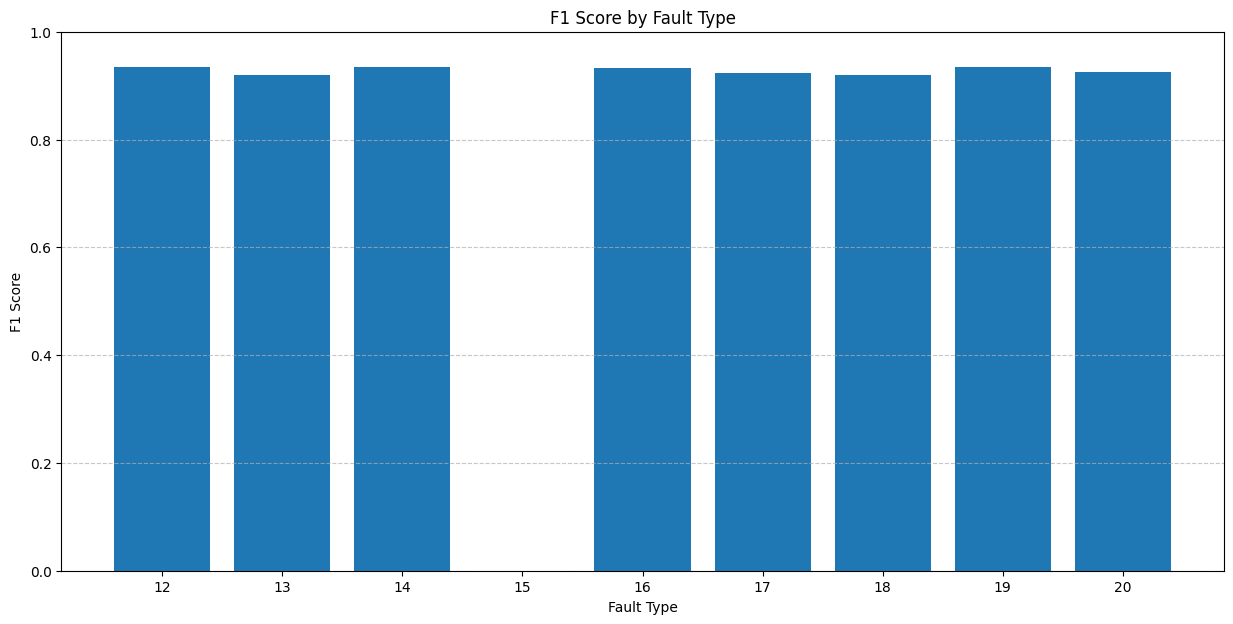

In [14]:
# Get all fault types
fault_types = sorted(df_train_faulty['faultNumber'].unique())
print(f"Found fault types: {fault_types}")

# Find the index of fault type 10
start_index = fault_types.index(12)
remaining_fault_types = fault_types[start_index:]
print(f"Will process the following fault types: {remaining_fault_types}")

# Store results for all fault types
all_results = {}

# Train and evaluate model for each remaining fault type
for fault_type in remaining_fault_types:
    print(f"\nProcessing fault type {fault_type}...")
    result = train_and_evaluate_fault_model(
        fault_type, 
        df_train_faultfree, 
        df_train_faulty, 
        df_test_faulty,
        lookback=15,
        num_epochs=30,
        batch_size=16
    )
    
    if result:
        all_results[fault_type] = result

# Summarize results
print("\n" + "="*80)
print("Summary of Results for All Fault Types")
print("="*80)

f1_scores = []
accuracies = []

for fault_type, result in all_results.items():
    if 'f1' in result:
        print(f"Fault {fault_type} - F1: {result['f1']:.4f}, Accuracy: {result['accuracy']:.4f}")
        f1_scores.append(result['f1'])
        accuracies.append(result['accuracy'])

if f1_scores:
    print("\nOverall Performance:")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    
    # Visualize F1 scores for different fault types
    plt.figure(figsize=(15, 7))
    fault_types = list(all_results.keys())
    f1_values = [result.get('f1', 0) if 'f1' in result else 0 for result in all_results.values()]
    
    plt.bar(fault_types, f1_values)
    plt.title('F1 Score by Fault Type')
    plt.xlabel('Fault Type')
    plt.ylabel('F1 Score')
    plt.xticks(fault_types)
    plt.ylim(0, 1.0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig('fault_comparison_f1.png')
    
    # Visualize precision and recall for different fault types
    plt.figure(figsize=(15, 7))
    precision_values = [result.get('precision', 0) if 'precision' in result else 0 for result in all_results.values()]
    recall_values = [result.get('recall', 0) if 'recall' in result else 0 for result in all_results.values()]
    
    x = np.arange(len(fault_types))
    width = 0.35
    
    plt.bar(x - width/2, precision_values, width, label='Precision')
    plt.bar(x + width/2, recall_values, width, label='Recall')
    
    plt.title('Precision and Recall by Fault Type')
    plt.xlabel('Fault Type')
    plt.ylabel('Score')
    plt.xticks(x, fault_types)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig('fault_comparison_precision_recall.png')
    
    plt.close()

**Recording and plotting the data for faults that were not properly saved due to unexpected interruptions.**

Fault 1 - F1: 0.9344, Accuracy: 0.8769
Fault 2 - F1: 0.9291, Accuracy: 0.8677
Fault 3 - F1: 0.9348, Accuracy: 0.8776
Fault 4 - F1: 0.9324, Accuracy: 0.8733
Fault 5 - F1: 0.9350, Accuracy: 0.8780
Fault 6 - F1: 0.9368, Accuracy: 0.8811
Fault 7 - F1: 0.9351, Accuracy: 0.8782
Fault 8 - F1: 0.9282, Accuracy: 0.8661
Fault 9 - F1: 0.9998, Accuracy: 0.9997
Fault 10 - F1: 0.9215, Accuracy: 0.8544
Fault 11 - F1: 0.9379, Accuracy: 0.8832


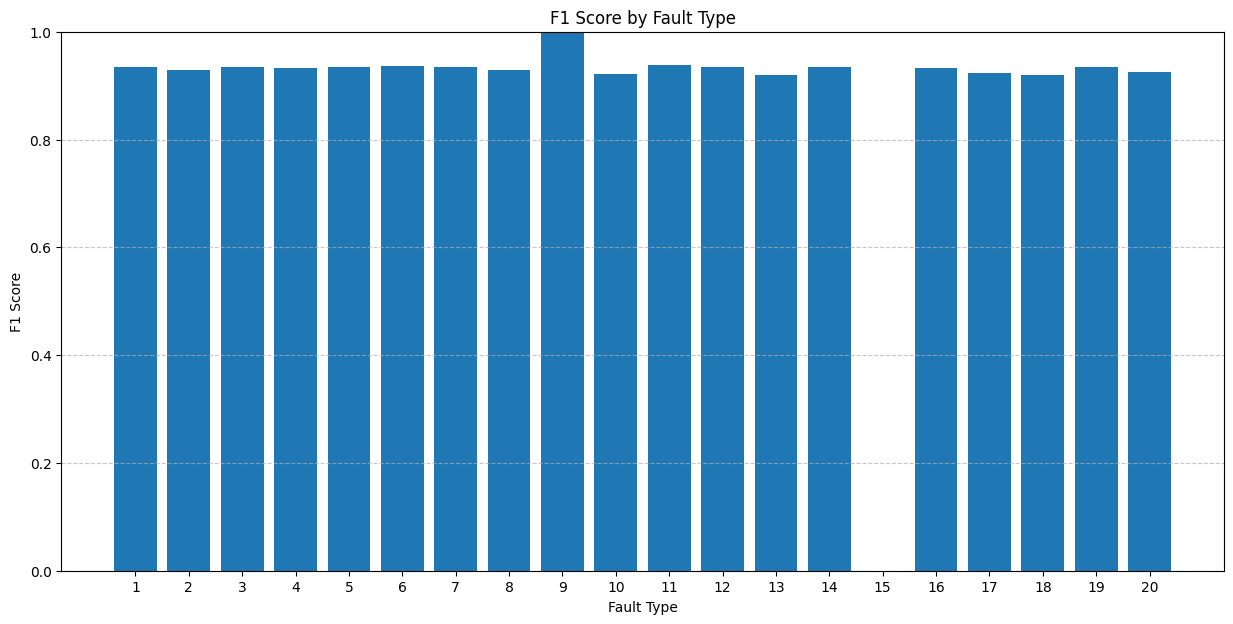

In [17]:
all_results[1] = {'f1': 0.9344, 'accuracy': 0.8769}
all_results[2] = {'f1': 0.9291, 'accuracy': 0.8677}
all_results[3] = {'f1': 0.9348, 'accuracy': 0.8776}
all_results[4] = {'f1': 0.9324, 'accuracy': 0.8733}
all_results[5] = {'f1': 0.9350, 'accuracy': 0.8780}
all_results[6] = {'f1': 0.9368, 'accuracy': 0.8811}
all_results[7] = {'f1': 0.9351, 'accuracy': 0.8782}
all_results[8] = {'f1': 0.9282, 'accuracy': 0.8661}
all_results[9] = {'f1': 0.9998, 'accuracy': 0.9997}
all_results[10] = {'f1': 0.9215, 'accuracy': 0.8544}
all_results[11] = {'f1': 0.9379, 'accuracy': 0.8832}

for fault_type in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:  
    if fault_type in all_results and 'f1' in all_results[fault_type]:
        result = all_results[fault_type]
        print(f"Fault {fault_type} - F1: {result['f1']:.4f}, Accuracy: {result['accuracy']:.4f}")
        f1_scores.append(result['f1'])
        accuracies.append(result['accuracy'])

# Visualize F1 scores for different fault types
plt.figure(figsize=(15, 7))
fault_types = list(all_results.keys())
f1_values = [result.get('f1', 0) if 'f1' in result else 0 for result in all_results.values()]
    
plt.bar(fault_types, f1_values)
plt.title('F1 Score by Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('F1 Score')
plt.xticks(fault_types)
plt.ylim(0, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('fault_comparison_f1.png')
    
# Visualize precision and recall for different fault types
plt.figure(figsize=(15, 7))
precision_values = [result.get('precision', 0) if 'precision' in result else 0 for result in all_results.values()]
recall_values = [result.get('recall', 0) if 'recall' in result else 0 for result in all_results.values()]
    
x = np.arange(len(fault_types))
width = 0.35
    
plt.bar(x - width/2, precision_values, width, label='Precision')
plt.bar(x + width/2, recall_values, width, label='Recall')
    
plt.title('Precision and Recall by Fault Type')
plt.xlabel('Fault Type')
plt.ylabel('Score')
plt.xticks(x, fault_types)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('fault_comparison_precision_recall.png')
    
plt.close()

**From the images above, we can see that Fault 15 achieved very low F1 score and accuracy due to dataset peculiarities and extremely subtle anomalies. After removing Fault 15 and calculating the average, we can determine the average performance of the TransKal model for anomaly detection on the TEP dataset.**

In [18]:
if f1_scores:
    filtered_f1_scores = [f1 for ft, f1 in zip(all_results.keys(), f1_scores) if ft != 15]
    filtered_accuracies = [acc for ft, acc in zip(all_results.keys(), accuracies) if ft != 15]
    
    print("\nOverall Performance:")
    print(f"Average F1 Score: {np.mean(filtered_f1_scores):.4f}")
    print(f"Average Accuracy: {np.mean(filtered_accuracies):.4f}")


Overall Performance:
Average F1 Score: 0.9343
Average Accuracy: 0.8771
